# 1. Project Overview

## Goal

The objective of this project is to determine whether we can accurately predict if a passenger aboard the Spaceship Titanic was **transported to another dimension** based on a variety of features including demographics, travel preferences, and onboard spending behavior.

## Dataset

- **Source**: [Kaggle – Spaceship Titanic](https://www.kaggle.com/competitions/spaceship-titanic)
- **Files Used**:
  - `train.csv`: Training data with labels (`Transported`)
  - `test.csv`: Test data for final submission
- **Size**:
  - ~8,700 records in training
  - ~4,300 records in test

## Target Variable

- `Transported`: A boolean indicating whether the passenger was transported during the anomaly (`True` or `False`)

## Project Objectives

This project aims to:
- Accurately predict the `Transported` outcome using classification models
- Understand which features most influence the likelihood of transportation
- Explore statistical patterns in space travel behavior, with potential applications in anomaly detection and passenger profiling

## Approach

The project follows a full data science pipeline:

### Exploratory Data Analysis (EDA)
- Understand feature distributions and class balance
- Visualize trends, outliers, and anomalies
- Use Phi-K correlation to examine nonlinear associations

### Statistical Inference
- Run hypothesis tests (e.g., Chi-Square) to identify statistically significant associations between features and the target
- Calculate confidence intervals for key proportions

### Feature Engineering
- Parse compound fields (`PassengerId`, `Cabin`)
- Create group-level features (`GroupSize`, `SpentAnything`)
- Encode binary and categorical variables

### Predictive Modeling
- Train and evaluate multiple models using:
  - Logistic Regression
  - SVM
  - Random Forest
  - CatBoost
  - XGBoost
  - Voting Ensemble (Top 3 models)
  - FLAML (AutoML)

### Model Optimization
- Hyperparameter tuning via:
  - `RandomizedSearchCV`
  - `Optuna` (Bayesian optimization)
- Threshold tuning for probability-based models

### Evaluation
- Use metrics such as:
  - Accuracy
  - ROC AUC
  - PR AUC
  - F1 Score
  - Precision & Recall
- Apply permutation importance for interpretability

### Conclusions and Recommendations
- Identify the best model based on validation performance
- Use optimized thresholds for final predictions
- Generate and export Kaggle submission files

---

### Imports and Setup


In [1]:
import time
import warnings

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as stats
import statsmodels.api as sm
from phik import phik_matrix

from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.calibration import CalibratedClassifierCV
from sklearn.compose import ColumnTransformer, make_column_selector
from sklearn.ensemble import RandomForestClassifier, VotingClassifier
from sklearn.impute import SimpleImputer
from sklearn.inspection import permutation_importance
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import (
    accuracy_score,
    average_precision_score,
    classification_report,
    confusion_matrix,
    f1_score,
    precision_score,
    recall_score,
    roc_auc_score,
    roc_curve,
)
from sklearn.model_selection import (
    RandomizedSearchCV,
    StratifiedKFold,
    train_test_split,
)
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder, StandardScaler, FunctionTransformer
from sklearn.svm import LinearSVC

from catboost import CatBoostClassifier
from xgboost import XGBClassifier
import optuna
from flaml import AutoML

from utils import (
    plot_transported_distribution,
    plot_feature_vs_transported,
    plot_spending_vs_transport,
    plot_phik_correlation,
    plot_class_balance,
    plot_permutation_importance,
    FeatureEngineer,
    tune_and_evaluate_with_optuna,
    evaluate_and_record,
)

warnings.filterwarnings("ignore", category=UserWarning)
warnings.filterwarnings("ignore", category=FutureWarning)
warnings.filterwarnings("ignore", category=UserWarning, module="tqdm")

## 3. Data Overview

The training dataset contains **8,693 rows** and **14 columns**, including demographic, cabin, and spending details for each passenger. The target variable is `Transported`, a boolean indicating whether the passenger was transported to another dimension.

### Data Types
- **Numerical Features (6)**: `Age`, `RoomService`, `FoodCourt`, `ShoppingMall`, `Spa`, `VRDeck`
- **Categorical Features (7)**: `PassengerId`, `HomePlanet`, `CryoSleep`, `Cabin`, `Destination`, `VIP`, `Name`
- **Binary Features (3 identified)**: `CryoSleep`, `VIP`, and `Transported`

### Key Observations
- Several features have **missing values**, with `Name` (200), `ShoppingMall` (208), and `VRDeck` (188) among the most affected.
- No duplicate rows were found.
- Spending features (like `RoomService`, `FoodCourt`, etc.) are **heavily right-skewed** and contain many zeros.
- `Age` ranges from **0 to 79**, with a median around **27 years**.
- Categorical columns like `HomePlanet`, `CryoSleep`, and `VIP` contain **3 or fewer unique values**, making them suitable for binary/categorical treatment.

This initial analysis guides preprocessing decisions such as imputation, encoding, and feature transformation.


In [2]:
df_train = pd.read_csv("train.csv")
print("Sample of training data:")
display(df_train.sample(n=10))

X_train = df_train.copy(deep=True)
X_train.info()
display(X_train.describe())

for col in X_train.select_dtypes(include="object").columns:
    print(f"\nColumn: {col}")
    print(X_train[col].unique())

categorical_features = X_train.select_dtypes(include=["object"]).columns.tolist()
numerical_features = X_train.select_dtypes(include=["number"]).columns.tolist()

possible_binary_cols = X_train.select_dtypes(
    include=["object", "bool", "number"]
).columns

binary_features = [
    col for col in possible_binary_cols if X_train[col].dropna().nunique() == 2
]

categorical_features = [
    col for col in categorical_features if col not in binary_features
]
numerical_features = [col for col in numerical_features if col not in binary_features]

num_unique_duplicated_rows = (
    X_train[X_train.duplicated(keep=False)].drop_duplicates().shape[0]
)
missing_per_column = X_train.isnull().sum()
num_rows_with_nan = X_train.isnull().any(axis=1).sum()
num_cols_with_nan = X_train.isnull().any(axis=0).sum()

print("Shape:", X_train.shape)
print("Duplicate rows:", X_train.duplicated(keep=False).sum())
print("Unique rows that have duplicates:", num_unique_duplicated_rows)
print("Rows with at least one NaN:", num_rows_with_nan)
print("Columns with at least one NaN:", num_cols_with_nan)
print(X_train["Transported"].value_counts(dropna=False))
print("Missing in 'Transported':", X_train["Transported"].isnull().sum())
print("Categorical Features:", categorical_features)
print("Numerical Features:", numerical_features)
print("Binary Features:", binary_features)
print("Missing values per column:")
print(missing_per_column)

Sample of training data:


,PassengerId,HomePlanet,CryoSleep,Cabin,Destination,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Name,Transported
6021,6368_01,Earth,False,G/1033/S,TRAPPIST-1e,26.0,False,360.0,8.0,1.0,329.0,185.0,Mayne Bartines,False
8114,8668_02,Mars,False,D/269/P,TRAPPIST-1e,41.0,False,806.0,16.0,125.0,1008.0,0.0,Mulk Rapie,False
4740,5060_02,Europa,True,C/157/P,TRAPPIST-1e,14.0,False,0.0,0.0,0.0,0.0,0.0,Instan Honatte,True
8089,8642_01,Earth,False,F/1774/P,PSO J318.5-22,20.0,False,0.0,4.0,0.0,0.0,625.0,Yolace Berreranks,False
7966,8509_01,Earth,False,G/1364/S,TRAPPIST-1e,43.0,False,21.0,0.0,863.0,0.0,0.0,Lillia Kaufmaneyes,False
3856,4131_01,Europa,True,C/147/S,TRAPPIST-1e,34.0,False,0.0,0.0,0.0,NaN,0.0,Achium Pokematic,True
7896,8431_02,Europa,NaN,B/277/P,55 Cancri e,26.0,False,1.0,4680.0,25.0,564.0,13.0,Zinoces Myling,False
7960,8504_01,Earth,False,F/1744/P,TRAPPIST-1e,44.0,False,0.0,0.0,2036.0,2.0,1.0,Catha Moranthons,True
5213,5561_01,Europa,True,A/51/P,TRAPPIST-1e,29.0,False,0.0,0.0,0.0,0.0,0.0,Diskeh Fueling,True
7154,7632_01,Mars,False,D/226/S,TRAPPIST-1e,28.0,False,2703.0,0.0,4.0,1.0,0.0,Phex Kepie,False


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8693 entries, 0 to 8692
Data columns (total 14 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   PassengerId   8693 non-null   object 
 1   HomePlanet    8492 non-null   object 
 2   CryoSleep     8476 non-null   object 
 3   Cabin         8494 non-null   object 
 4   Destination   8511 non-null   object 
 5   Age           8514 non-null   float64
 6   VIP           8490 non-null   object 
 7   RoomService   8512 non-null   float64
 8   FoodCourt     8510 non-null   float64
 9   ShoppingMall  8485 non-null   float64
 10  Spa           8510 non-null   float64
 11  VRDeck        8505 non-null   float64
 12  Name          8493 non-null   object 
 13  Transported   8693 non-null   bool   
dtypes: bool(1), float64(6), object(7)
memory usage: 891.5+ KB


,Age,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck
count,8514.000000,8512.000000,8510.000000,8485.000000,8510.000000,8505.000000
mean,28.827930,224.687617,458.077203,173.729169,311.138778,304.854791
std,14.489021,666.717663,1611.489240,604.696458,1136.705535,1145.717189
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,19.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,27.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,38.000000,47.000000,76.000000,27.000000,59.000000,46.000000
max,79.000000,14327.000000,29813.000000,23492.000000,22408.000000,24133.000000



Column: PassengerId
['0001_01' '0002_01' '0003_01' ... '9279_01' '9280_01' '9280_02']

Column: HomePlanet
['Europa' 'Earth' 'Mars' nan]

Column: CryoSleep
[False True nan]

Column: Cabin
['B/0/P' 'F/0/S' 'A/0/S' ... 'G/1499/S' 'G/1500/S' 'E/608/S']

Column: Destination
['TRAPPIST-1e' 'PSO J318.5-22' '55 Cancri e' nan]

Column: VIP
[False True nan]

Column: Name
['Maham Ofracculy' 'Juanna Vines' 'Altark Susent' ... 'Fayey Connon'
 'Celeon Hontichre' 'Propsh Hontichre']
Shape: (8693, 14)
Duplicate rows: 0
Unique rows that have duplicates: 0
Rows with at least one NaN: 2087
Columns with at least one NaN: 12
Transported
True     4378
False    4315
Name: count, dtype: int64
Missing in 'Transported': 0
Categorical Features: ['PassengerId', 'HomePlanet', 'Cabin', 'Destination', 'Name']
Numerical Features: ['Age', 'RoomService', 'FoodCourt', 'ShoppingMall', 'Spa', 'VRDeck']
Binary Features: ['CryoSleep', 'VIP', 'Transported']
Missing values per column:
PassengerId       0
HomePlanet      201


### 4. Feature Engineering

After applying the custom `FeatureEngineer` transformer, the dataset was enhanced with several informative features:

- **GroupID** and **GroupMember**: Extracted from `PassengerId`, indicating group associations among passengers.
- **Deck**, **CabinNum**, and **Side**: Parsed from the `Cabin` string to capture spatial information aboard the ship.
- **FirstName** and **LastName**: Separated from the `Name` column, useful for family-related inference or matching.
- **GroupSize**: Computed from `GroupID` to reflect the size of the passenger's travel group.
- **SpentAnything**: A new binary feature indicating whether the passenger spent on any amenities (`RoomService`, `FoodCourt`, `ShoppingMall`, `Spa`, `VRDeck`).

These features aim to capture group behavior, passenger location, and activity level—factors likely to influence the probability of being transported. The transformed dataset is now ready for analysis and modeling.


In [3]:
feature_engineer = FeatureEngineer()
X_train = feature_engineer.transform(X_train)
print("Sample after feature engineering:")
display(X_train.sample(10))

Sample after feature engineering:


,HomePlanet,CryoSleep,Destination,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Transported,GroupID,GroupMember,Deck,CabinNum,Side,FirstName,LastName,GroupSize,SpentAnything
7725,Earth,False,TRAPPIST-1e,18.0,False,0.0,44.0,0.0,795.0,69.0,False,8243,01,G,1331,S,Jonard,Cooks,1,True
7674,Earth,False,PSO J318.5-22,18.0,False,0.0,0.0,19.0,751.0,4.0,False,8191,01,G,1320,S,Gracy,Gaington,1,True
8533,Mars,False,TRAPPIST-1e,38.0,False,1478.0,0.0,631.0,0.0,0.0,False,9111,01,E,598,S,Chars,Gecre,1,True
7548,Earth,False,TRAPPIST-1e,20.0,False,0.0,52.0,0.0,110.0,614.0,False,8068,01,F,1545,S,Eduard,Mcfarmerson,1,True
5794,Earth,True,TRAPPIST-1e,32.0,False,0.0,0.0,0.0,0.0,0.0,True,6137,03,G,994,S,Hary,Serry,6,False
6503,Earth,False,TRAPPIST-1e,25.0,False,0.0,10.0,909.0,0.0,17.0,False,6863,01,F,1311,S,Franda,Patrichane,1,True
3552,Earth,False,TRAPPIST-1e,24.0,False,58.0,0.0,4.0,789.0,54.0,False,3816,01,E,225,P,Scotte,Carterson,1,True
8006,Earth,True,PSO J318.5-22,19.0,False,0.0,0.0,0.0,0.0,0.0,False,8570,01,G,1377,S,Denny,Russon,1,False
7260,Earth,False,55 Cancri e,14.0,NaN,325.0,0.0,19.0,506.0,2.0,False,7763,01,G,1254,S,Dessie,Lewinez,1,True
3315,Mars,True,TRAPPIST-1e,43.0,False,0.0,0.0,0.0,0.0,0.0,True,3561,01,F,738,P,Skies,Oncy,2,False


### 5. Exploratory Data Analysis (EDA)

This section explores how various features relate to the target variable `Transported` through visualizations and correlation analysis.

#### Visualizations
- **Class Distribution**  
  - Approximately balanced classes — roughly 50% of passengers were transported.

- **Feature Relationships**
  - **CryoSleep:** Strongly associated with being transported — passengers in CryoSleep had a much higher transport rate.
  - **HomePlanet:** Differences observed — passengers from Europa were more likely to be transported compared to Earth or Mars.
  - **VIP:** VIP status appears negatively correlated with transportation — non-VIPs were more often transported.
  - **Deck and Side:** Passengers on certain decks (e.g., F, G) and sides (P/S) showed differing transport probabilities.
  - **Destination:** Some destinations (e.g., TRAPPIST-1e) were associated with higher transport likelihood.
  - **SpentAnything:** Spending on amenities shows an inverse relationship — passengers who spent **nothing** were more likely to be transported.

- **Numerical Features**
  - **Age:** Younger passengers (especially children and teens) had higher transport rates.
  - **Amenity Spending:** Most passengers spent little to nothing, but high spenders tended to be less likely to be transported.
  - **GroupSize:** Small groups or solo travelers had slightly higher transportation rates.

#### Phi-K Correlation Heatmap
- Confirms strong associations between `Transported` and:
  - `CryoSleep`
  - `HomePlanet`
  - `Deck`
  - `SpentAnything`
- Highlights nonlinear or categorical correlations better than Pearson/Spearman.

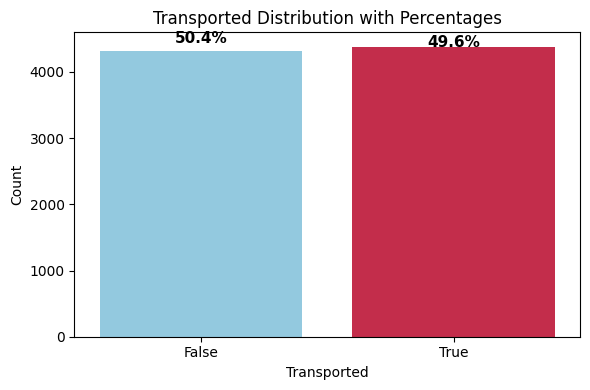

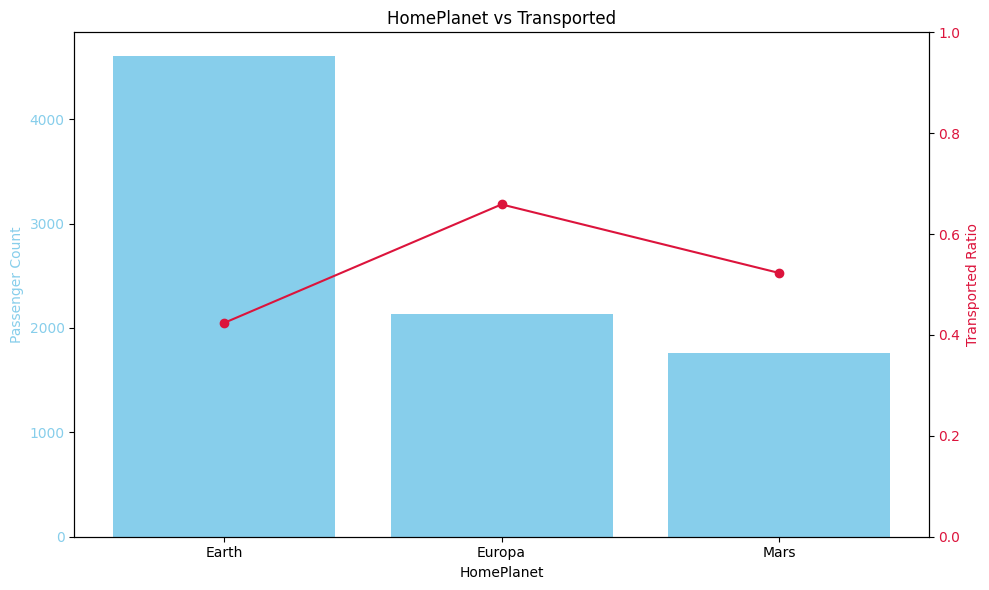

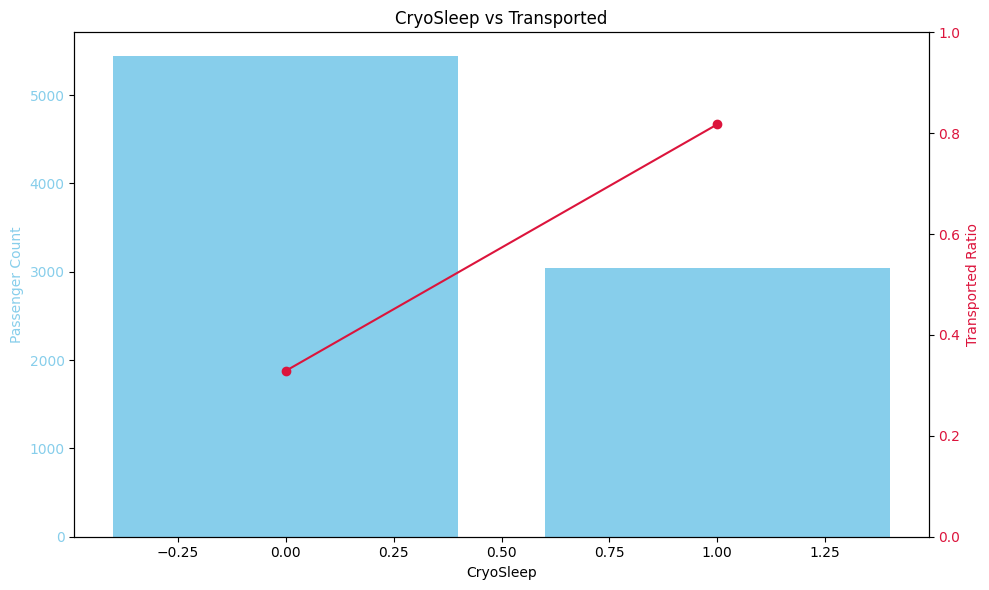

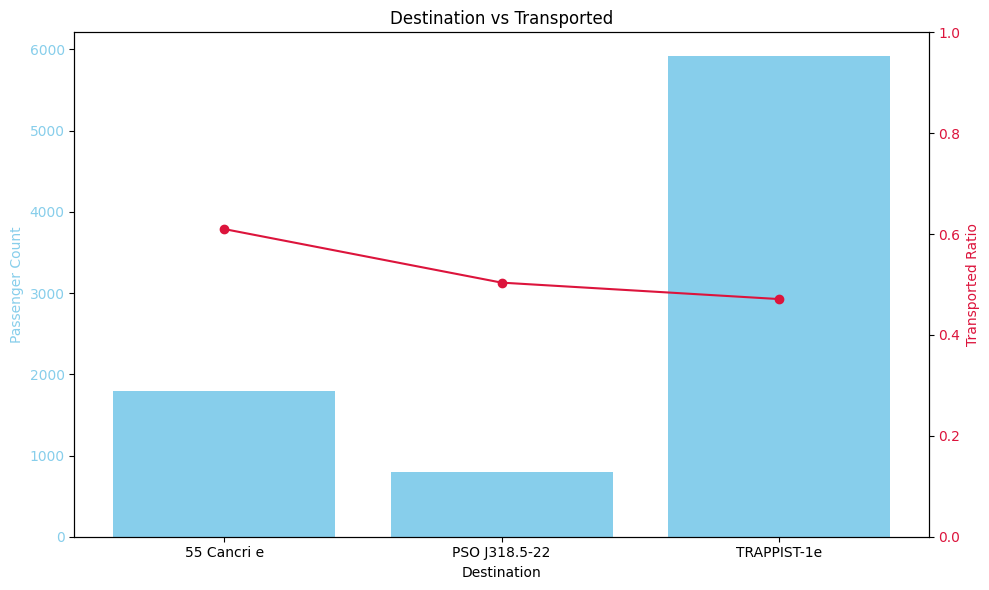

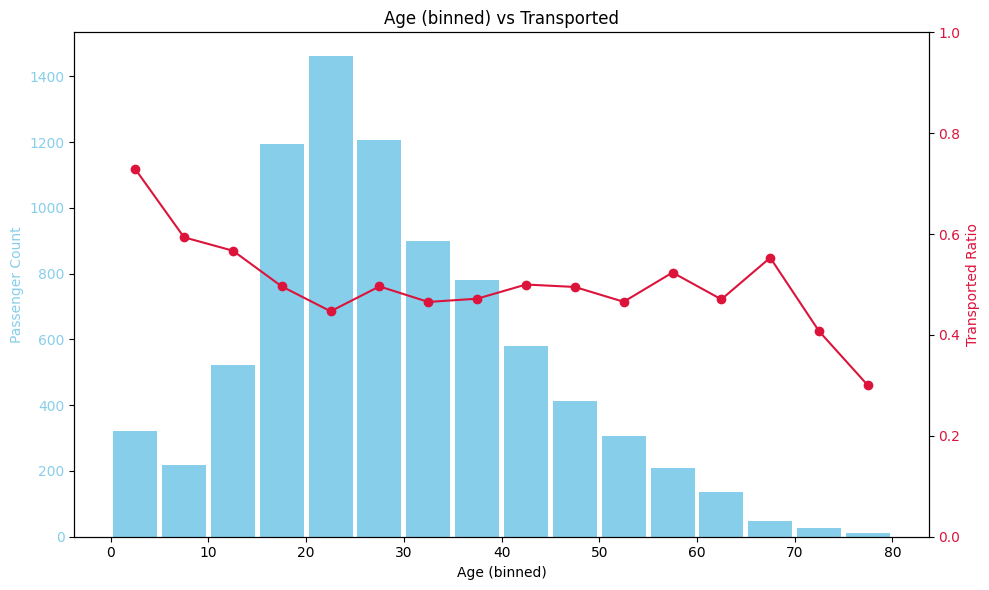

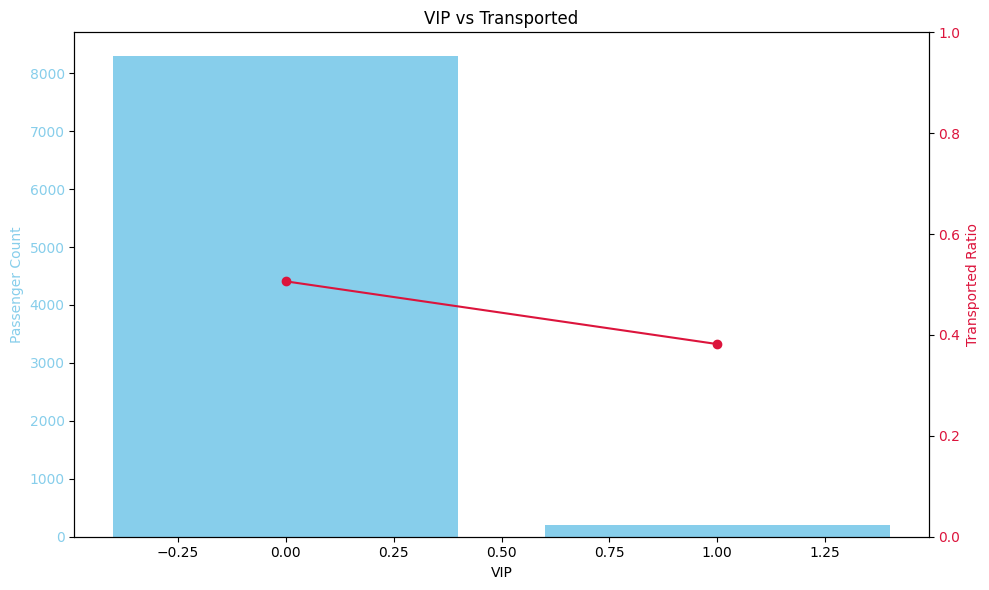

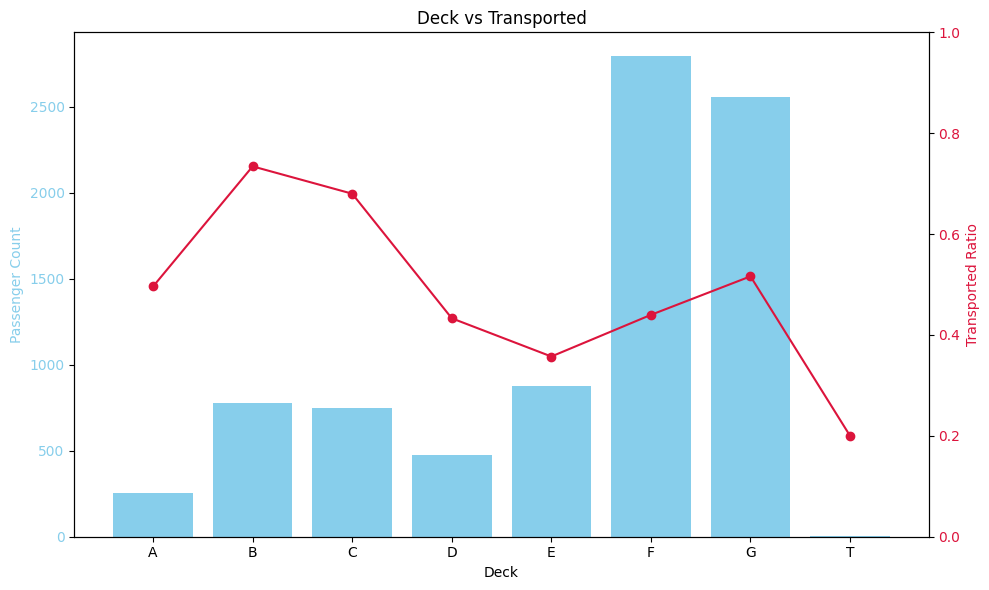

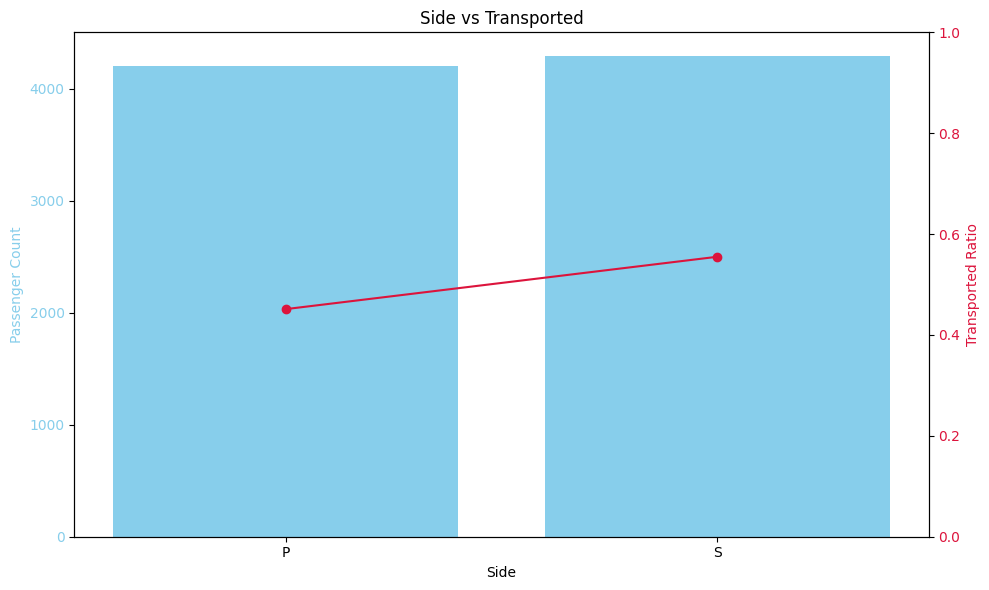

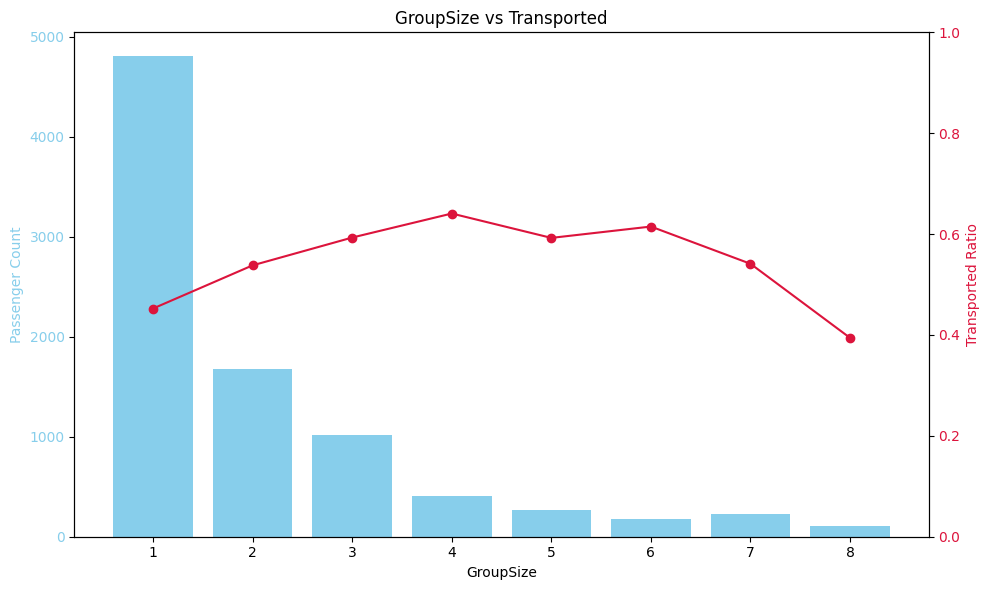

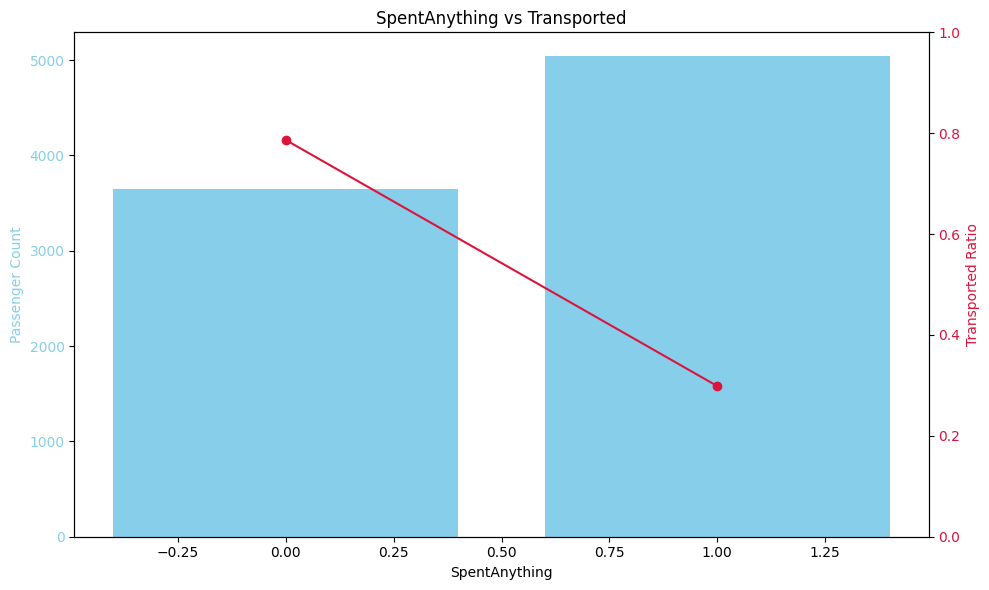

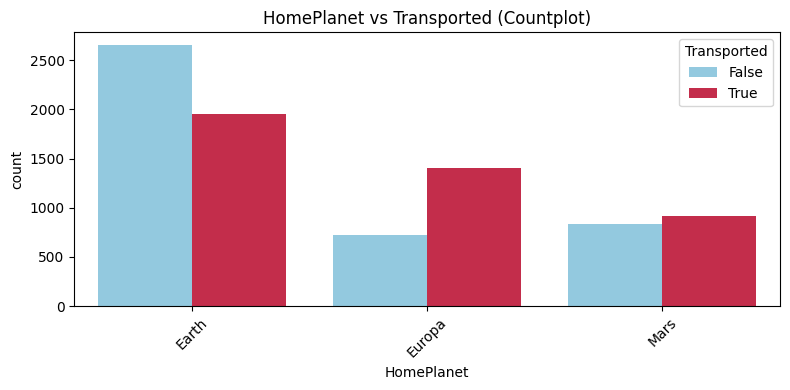

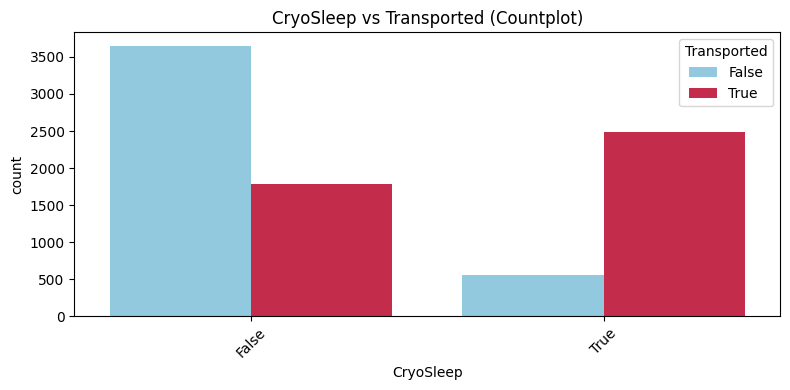

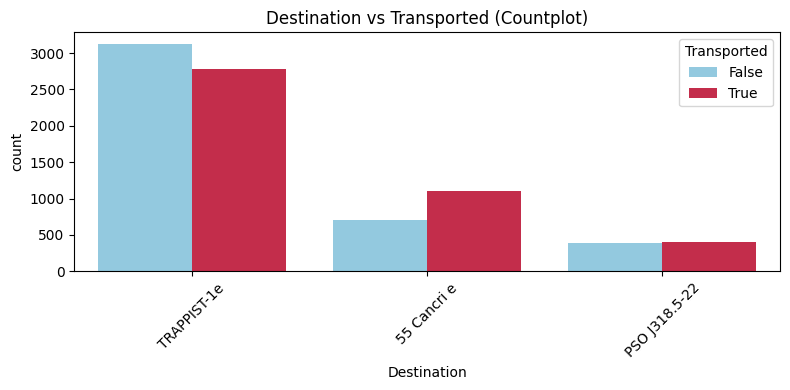

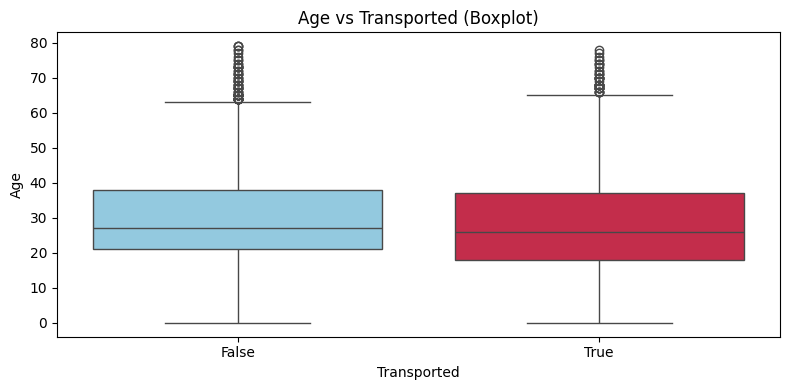

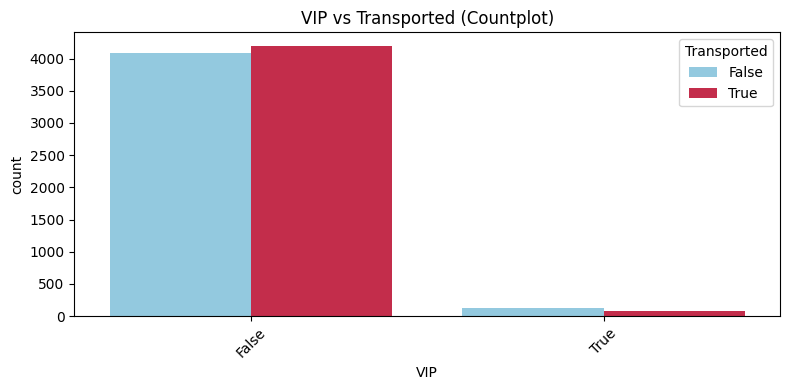

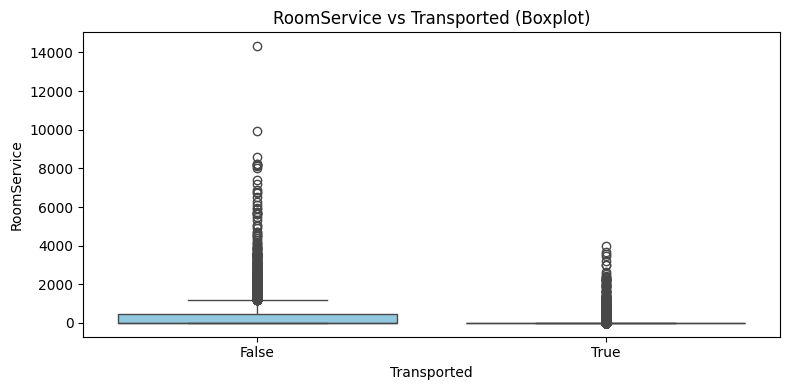

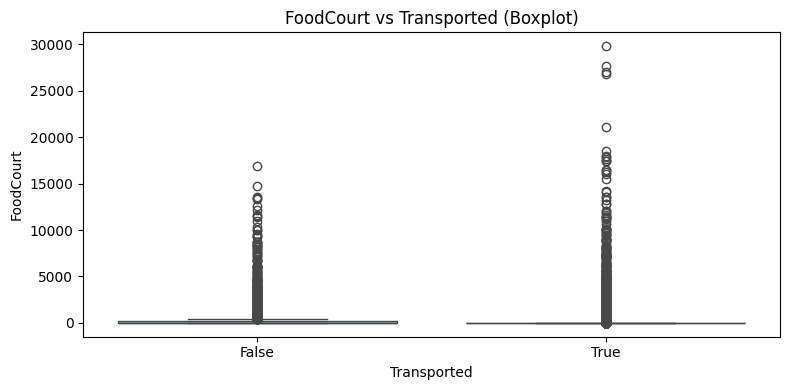

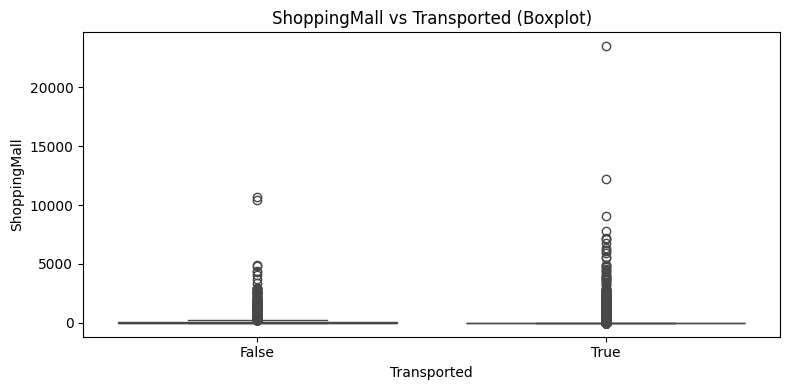

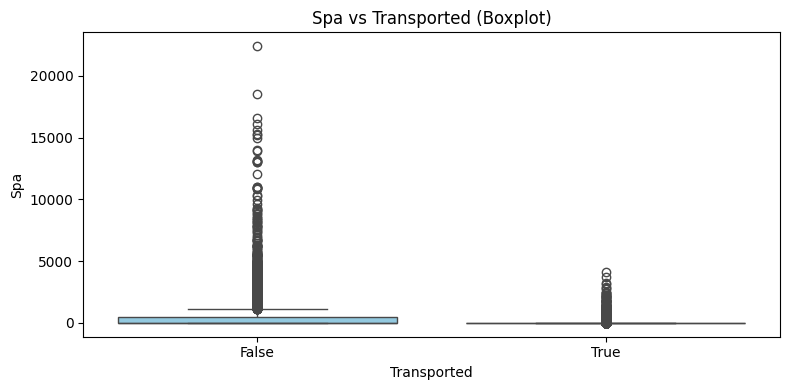

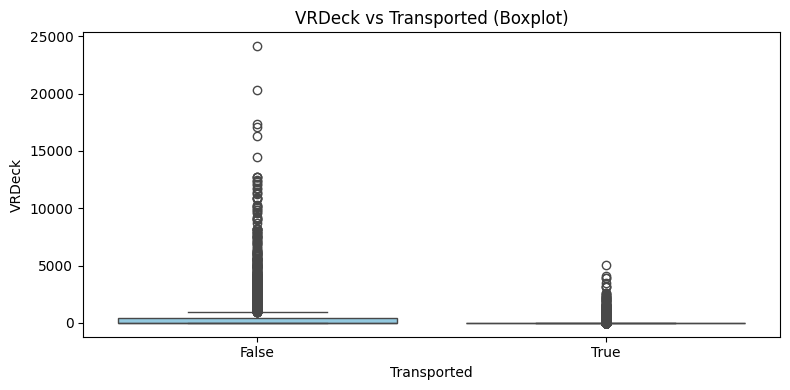

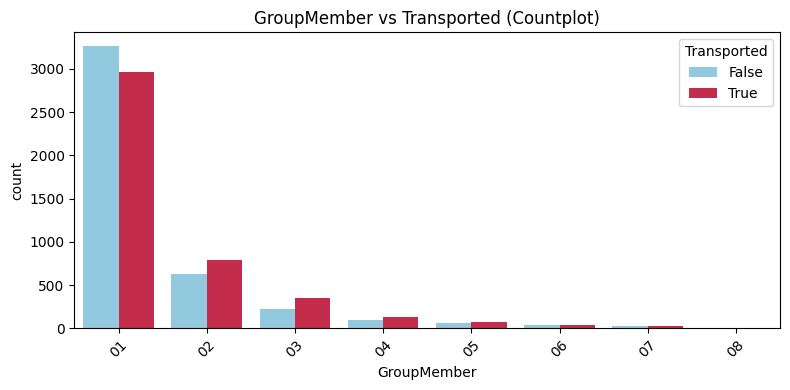

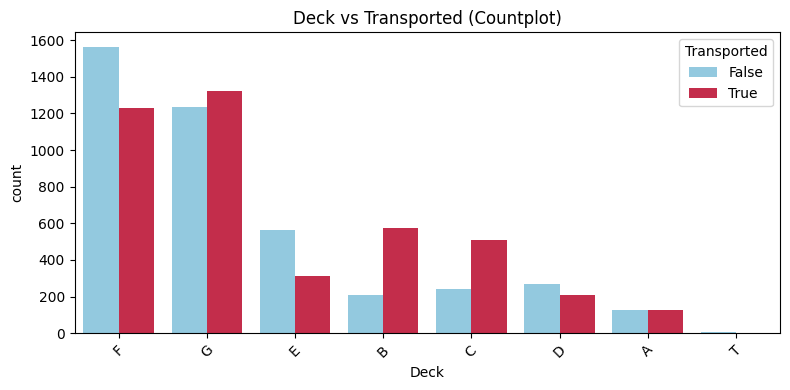

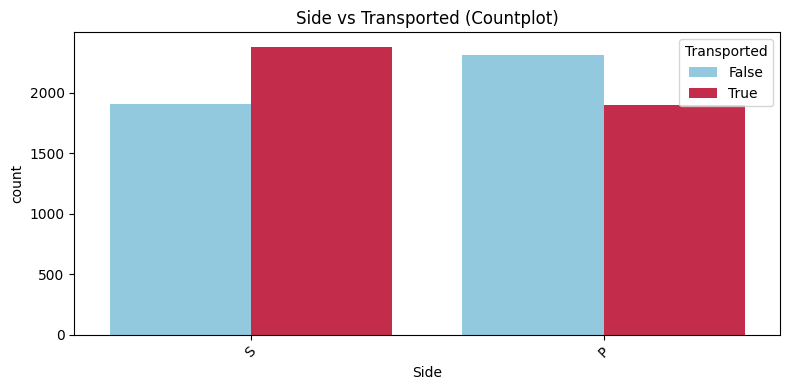

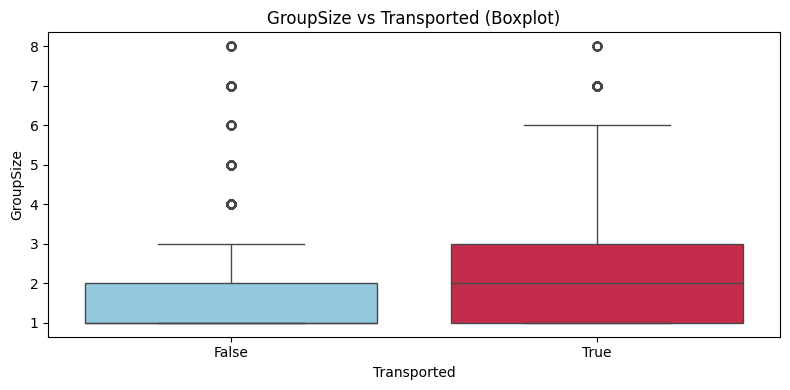

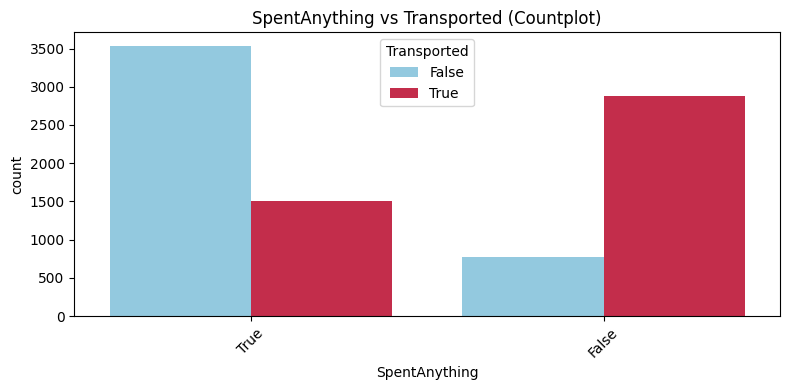

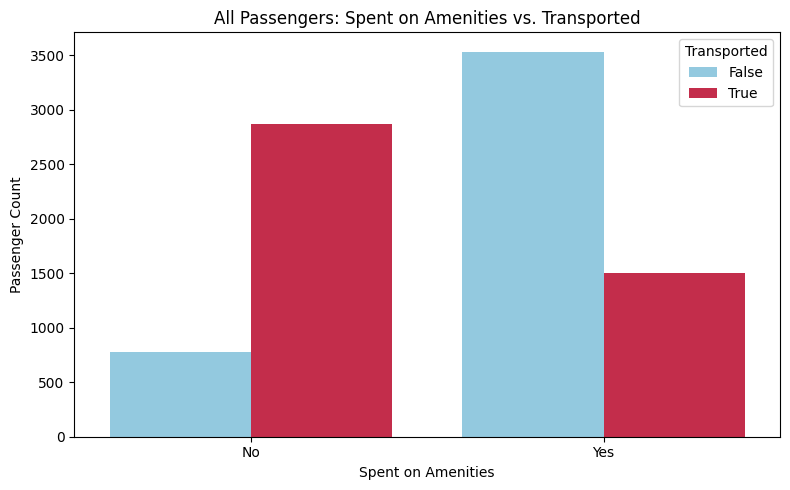

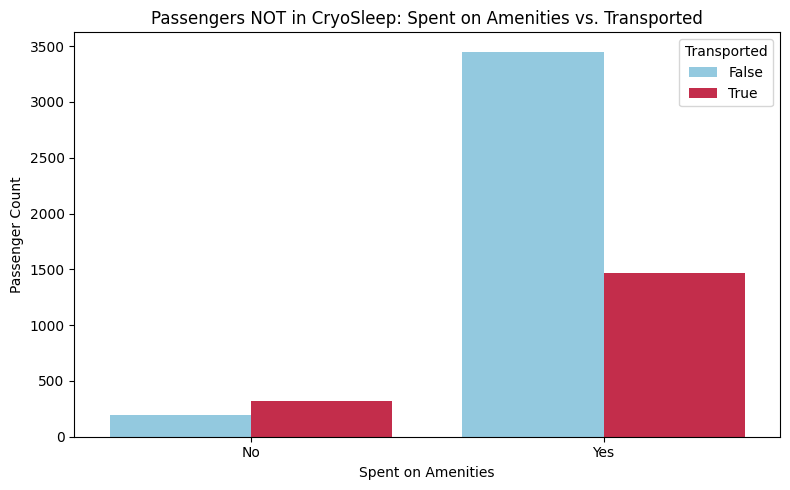

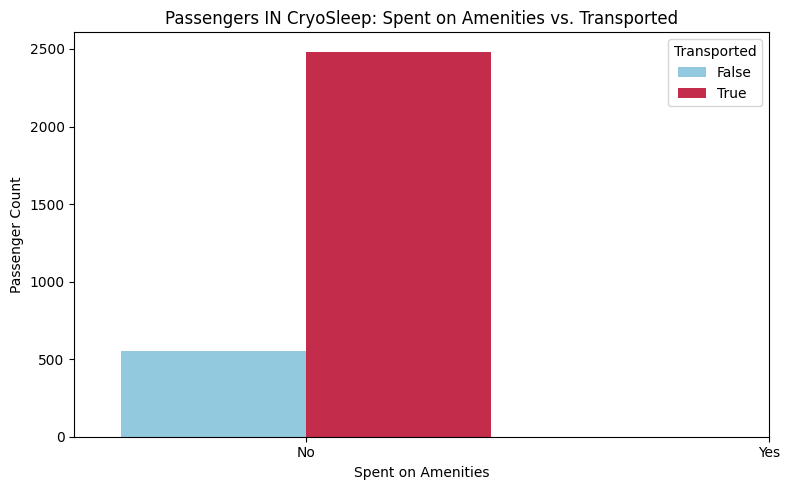

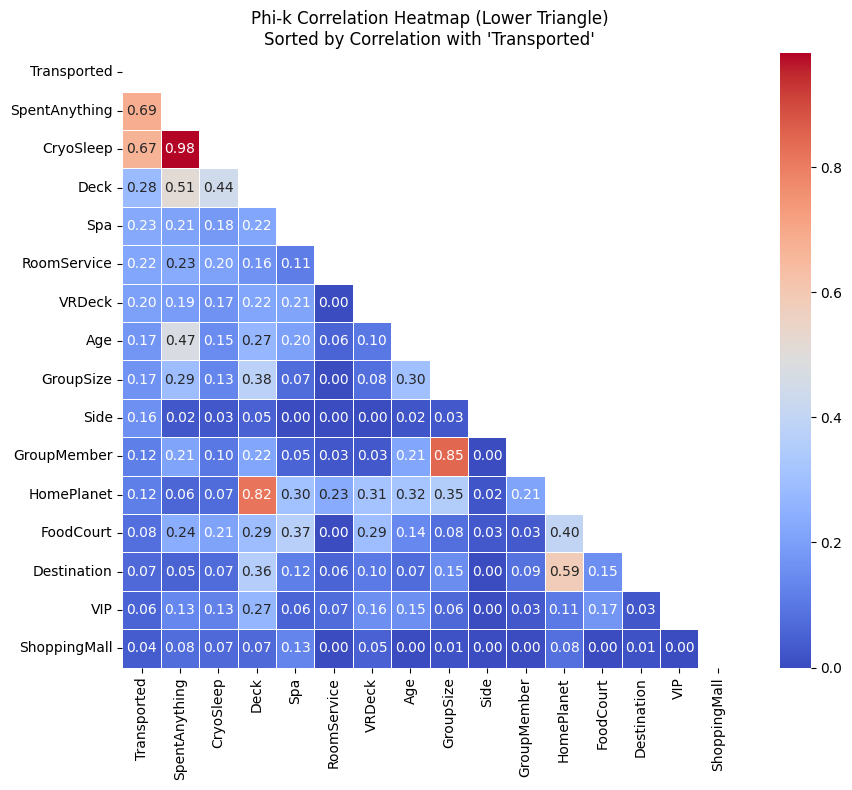

In [4]:
plot_transported_distribution(X_train)

excluded = [
    "FirstName",
    "LastName",
    "CabinNum",
    "GroupID",
    "GroupMember",
    "Transported",
]

for feature in X_train.columns:
    if feature not in excluded:
        if feature == "Age":
            plot_feature_vs_transported(
                X_train, feature, bins=range(0, 91, 5), bar_width=4.5
            )
        else:
            plot_feature_vs_transported(X_train, feature, bar_width=0.8)

colors = ["skyblue", "crimson"]
excluded_cols = ["Transported", "FirstName", "LastName", "CabinNum", "GroupID"]

for col in X_train.columns:
    if col in excluded_cols:
        continue

    plt.figure(figsize=(8, 4))

    if X_train[col].dtype in ["float64", "int64"]:
        sns.boxplot(x="Transported", y=col, data=X_train, palette=colors)
        plt.title(f"{col} vs Transported (Boxplot)")

    else:
        sns.countplot(
            x=col,
            hue="Transported",
            data=X_train,
            order=X_train[col].value_counts().index,
            palette=colors,
        )
        plt.title(f"{col} vs Transported (Countplot)")
        plt.xticks(rotation=45)

    plt.tight_layout()
    plt.show()

plot_spending_vs_transport(X_train, cryo_filter=None, title_suffix="All Passengers")
plot_spending_vs_transport(
    X_train, cryo_filter=False, title_suffix="Passengers NOT in CryoSleep"
)
plot_spending_vs_transport(
    X_train, cryo_filter=True, title_suffix="Passengers IN CryoSleep"
)

df_phik = X_train.drop(columns=["FirstName", "LastName", "CabinNum", "GroupID"]).copy()
interval_cols = [
    "Age",
    "RoomService",
    "FoodCourt",
    "ShoppingMall",
    "Spa",
    "VRDeck",
    "GroupSize",
]
plot_phik_correlation(df_phik, interval_cols)

### 6. Statistical Inference

This section evaluates the statistical association between selected categorical features and the target variable `Transported` using Chi-Square tests and confidence intervals for proportions.

#### Key Findings

- **CryoSleep**  
  - Statistically significant association (p < 0.0001)  
  - Passengers in CryoSleep had a high transport rate of 81.8%, compared to 32.9% for those not in CryoSleep.  
  - This suggests a strong link between being in CryoSleep and likelihood of transport.

- **HomePlanet**  
  - Statistically significant (p < 0.0001)  
  - Passengers from Europa had the highest transport rate (65.9%), while Earth had the lowest (42.4%).  
  - The planet of origin appears to influence transport outcomes.

- **Deck**  
  - Significant association detected (p < 0.0001)  
  - Decks B and C showed higher transport rates (over 68%), while Deck T had the lowest (20%), although this deck had few samples.  
  - Suggests cabin deck location may be a proxy for passenger status or placement patterns.

- **Side**  
  - Statistically significant (p < 0.0001)  
  - Passengers on the starboard side (S) were transported more often (55.5%) than those on the port side (P) at 45.1%.

- **SpentAnything**  
  - Strong statistical association (p < 0.0001)  
  - Counterintuitively, passengers who spent nothing were transported at a much higher rate (78.6%) than those who spent on amenities (29.9%).  
  - This aligns with the CryoSleep effect, as spending often implies they were awake during the journey.

#### Visual Summary

Bar plots with 95% confidence intervals were generated for each categorical feature, showing the proportion of transported passengers per category. These plots help visualize both the trends and the reliability of the estimates.

The findings reinforce the predictive value of these categorical features and guide informed feature selection for modeling.


Chi-Square Test for CryoSleep vs. Transported: chi2=1859.61, p-value=0.0000
  -> Significant association (reject null).
    False: Proportion=0.329, CI=[0.316, 0.341]
    True: Proportion=0.818, CI=[0.804, 0.831]



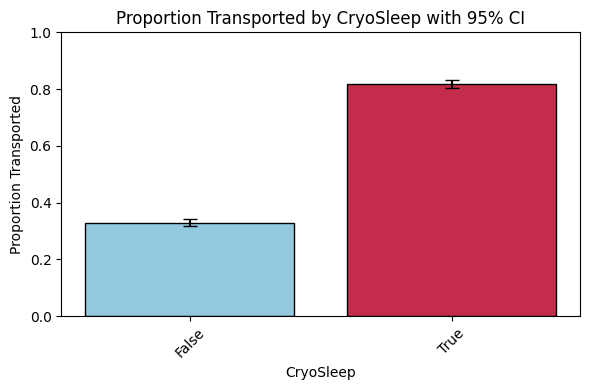

Chi-Square Test for HomePlanet vs. Transported: chi2=324.90, p-value=0.0000
  -> Significant association (reject null).
    Earth: Proportion=0.424, CI=[0.410, 0.438]
    Europa: Proportion=0.659, CI=[0.639, 0.679]
    Mars: Proportion=0.523, CI=[0.500, 0.546]



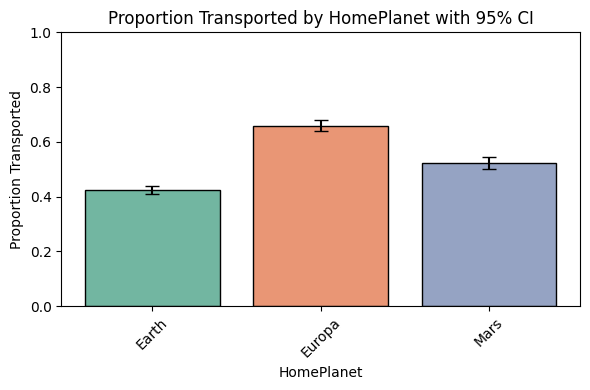

Chi-Square Test for Deck vs. Transported: chi2=392.29, p-value=0.0000
  -> Significant association (reject null).
    A: Proportion=0.496, CI=[0.435, 0.557]
    B: Proportion=0.734, CI=[0.703, 0.765]
    C: Proportion=0.680, CI=[0.647, 0.714]
    D: Proportion=0.433, CI=[0.389, 0.477]
    E: Proportion=0.357, CI=[0.326, 0.389]
    F: Proportion=0.440, CI=[0.421, 0.458]
    G: Proportion=0.516, CI=[0.497, 0.536]
    T: Proportion=0.200, CI=[0.000, 0.551]



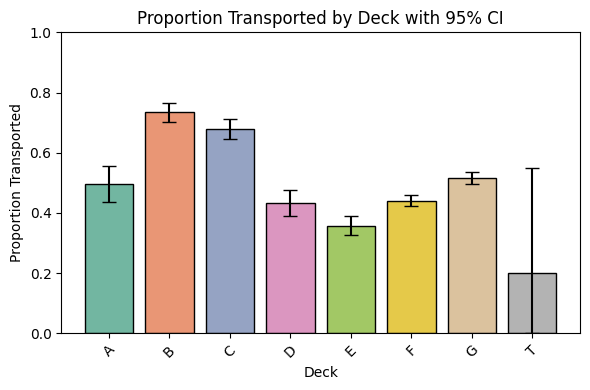

Chi-Square Test for Side vs. Transported: chi2=91.06, p-value=0.0000
  -> Significant association (reject null).
    P: Proportion=0.451, CI=[0.436, 0.466]
    S: Proportion=0.555, CI=[0.540, 0.570]



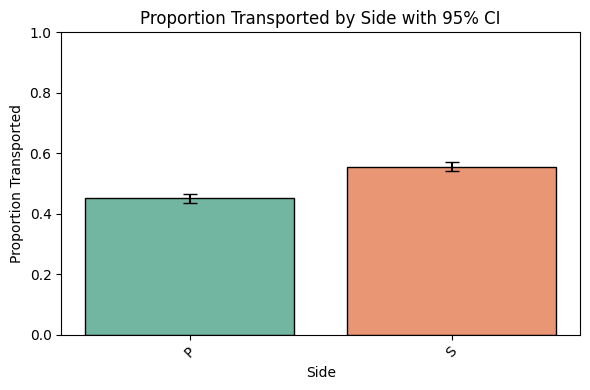

Chi-Square Test for SpentAnything vs. Transported: chi2=2014.53, p-value=0.0000
  -> Significant association (reject null).
    False: Proportion=0.786, CI=[0.773, 0.800]
    True: Proportion=0.299, CI=[0.286, 0.311]



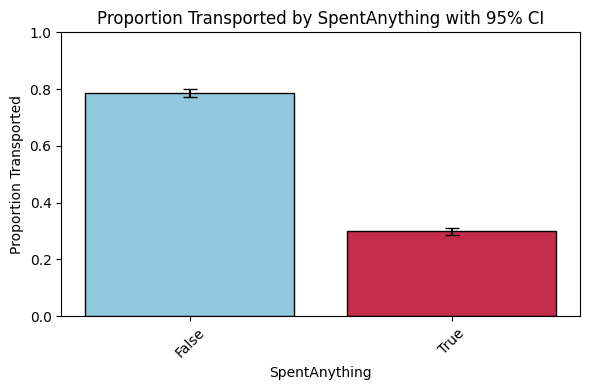

In [5]:
custom_colors = {"False": "skyblue", "True": "crimson"}

palette_fallback = sns.color_palette("Set2")

selected_features = ["CryoSleep", "HomePlanet", "Deck", "Side", "SpentAnything"]

for feature in selected_features:
    if feature in X_train.columns:
        # Chi-Square Test
        contingency_table = pd.crosstab(X_train[feature], X_train["Transported"])
        chi2, p, dof, expected = stats.chi2_contingency(contingency_table)
        print(
            f"Chi-Square Test for {feature} vs. Transported: chi2={chi2:.2f}, p-value={p:.4f}"
        )
        if p < 0.05:
            print(f"  -> Significant association (reject null).")

        plot_data = []
        color_list = []
        for i, group in enumerate(contingency_table.index):
            transported = (
                contingency_table.loc[group, True]
                if True in contingency_table.columns
                else 0
            )
            total = contingency_table.loc[group].sum()
            if total > 0:
                prop = transported / total
                ci_low, ci_high = sm.stats.proportion_confint(
                    transported, total, alpha=0.05, method="normal"
                )
                plot_data.append(
                    {
                        feature: str(group),
                        "Proportion": prop,
                        "CI Low": ci_low,
                        "CI High": ci_high,
                    }
                )
                group_str = str(group)
                color = custom_colors.get(
                    group_str, palette_fallback[i % len(palette_fallback)]
                )
                color_list.append(color)

                print(
                    f"    {group}: Proportion={prop:.3f}, CI=[{ci_low:.3f}, {ci_high:.3f}]"
                )
        print()

        plot_df = pd.DataFrame(plot_data)

        plt.figure(figsize=(6, 4))
        bars = sns.barplot(
            x=feature,
            y="Proportion",
            data=plot_df,
            palette=color_list,
            edgecolor="black",
        )

        plt.errorbar(
            x=range(len(plot_df)),
            y=plot_df["Proportion"],
            yerr=[
                plot_df["Proportion"] - plot_df["CI Low"],
                plot_df["CI High"] - plot_df["Proportion"],
            ],
            fmt="none",
            c="black",
            capsize=5,
        )

        plt.title(f"Proportion Transported by {feature} with 95% CI")
        plt.ylabel("Proportion Transported")
        plt.ylim(0, 1)
        plt.xticks(rotation=45)
        plt.tight_layout()
        plt.show()

### 7. Train/Validation Split and Class Balance

The dataset is split into training and validation sets using an 80/20 stratified split to ensure class balance in both subsets. The target variable `Transported` is separated from the features, and non-informative identifiers (`GroupID`, `FirstName`, `LastName`) are dropped. We will be using a separate test set provided by Kaggle for this competition.

A class balance plot confirms that both the training and validation sets maintain the proportion of `Transported = True` vs. `False` cases as in the original dataset. This balance is important for training fair models without introducing bias.

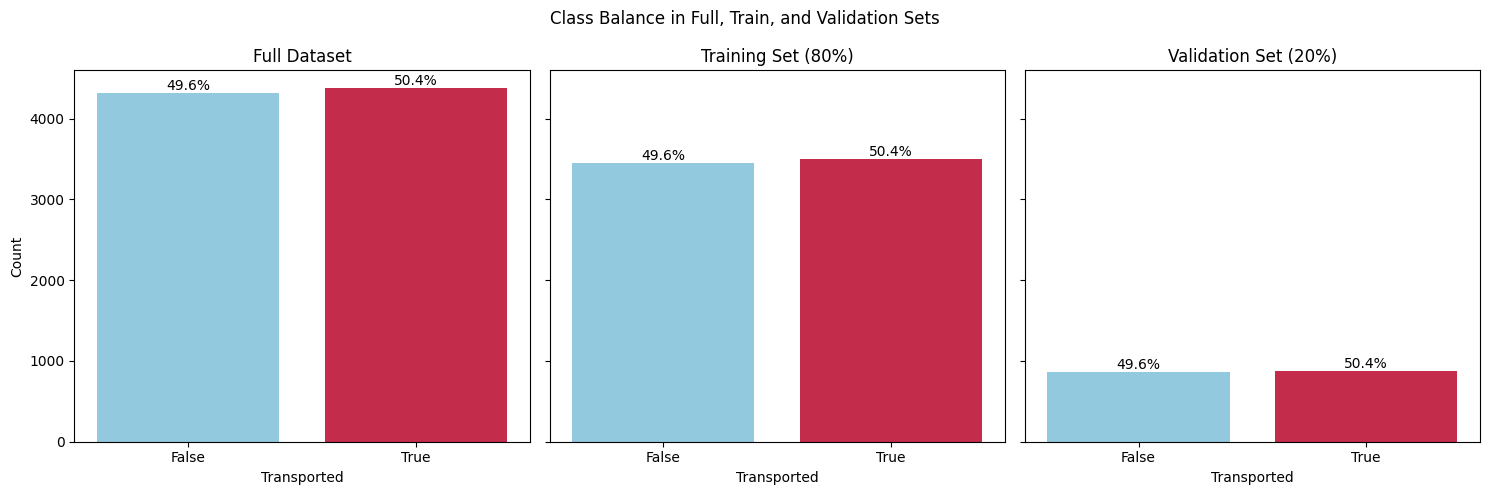

In [6]:
y = X_train["Transported"]
X = X_train.drop(columns="Transported")

X_train_split, X_val, y_train, y_val = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

drop_cols = ["GroupID", "FirstName", "LastName"]
X_train_split = X_train_split.drop(columns=drop_cols, errors="ignore")
X_val = X_val.drop(columns=drop_cols, errors="ignore")

plot_class_balance(y, y_train, y_val)

### 8. Baseline Model — Logistic Regression

A baseline logistic regression model is trained using a complete preprocessing pipeline:

- **Numerical Features**: Imputed with the mean and scaled with `StandardScaler`.
- **Categorical Features**: Imputed with the most frequent category and one-hot encoded.
- **Feature Engineering**: Applied using a custom `FeatureEngineer` transformer.

This model serves as a benchmark before advanced hyperparameter tuning or ensemble methods are applied.

**Performance Summary** (Validation Set):
- **Accuracy**: ~79.2%
- **ROC AUC**: ~0.88
- **PR AUC**: ~0.89
- **F1 Score**: ~0.80
- **Precision**: ~0.79
- **Recall**: ~0.80

These results indicate that even a simple, untuned model captures meaningful patterns in the data. It establishes a strong starting point for further optimization.



Evaluation — Logistic Regression (Baseline)
              precision    recall  f1-score   support

       False       0.80      0.78      0.79       863
        True       0.79      0.80      0.80       876

    accuracy                           0.79      1739
   macro avg       0.79      0.79      0.79      1739
weighted avg       0.79      0.79      0.79      1739



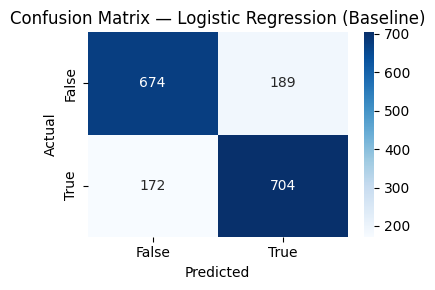

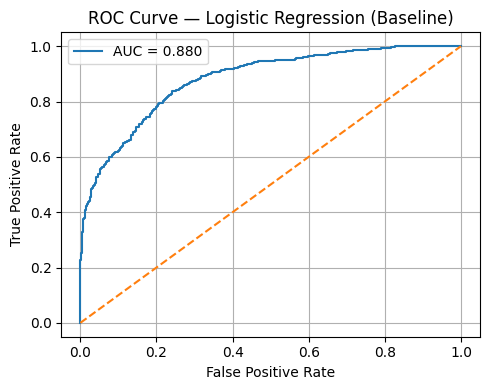

,Model,Accuracy,ROC AUC,PR AUC,F1,Precision,Recall,Best Params,Runtime (s)
0,Logistic Regression (Baseline),0.792409,0.879875,0.890106,0.79593,0.788354,0.803653,Default config,2.84


In [7]:
# Global results tracker
ALL_RESULTS = []

# Full preprocessing pipeline

numeric_transformer = Pipeline(
    [("imputer", SimpleImputer(strategy="mean")), ("scaler", StandardScaler())]
)

categorical_transformer = Pipeline(
    [
        ("imputer", SimpleImputer(strategy="most_frequent")),
        ("encoder", OneHotEncoder(handle_unknown="ignore", sparse_output=False)),
    ]
)

preprocessor = ColumnTransformer(
    [
        (
            "num",
            numeric_transformer,
            make_column_selector(dtype_include=["int64", "float64"]),
        ),
        (
            "cat",
            categorical_transformer,
            make_column_selector(dtype_include=["object", "category", "bool"]),
        ),
    ]
)

full_pipeline = Pipeline(
    [("feature_engineering", FeatureEngineer()), ("preprocessor", preprocessor)]
)

baseline_pipeline = Pipeline(
    [
        ("feature_engineering", FeatureEngineer()),
        ("preprocessor", preprocessor),
        ("classifier", LogisticRegression()),
    ]
)

start = time.time()
baseline_pipeline.fit(X_train_split, y_train)
y_proba = baseline_pipeline.predict_proba(X_val)[:, 1]

evaluate_and_record(
    name="Logistic Regression (Baseline)",
    model=baseline_pipeline,
    X_val=X_val,
    y_val=y_val,
    proba=y_proba,
    threshold=0.5,
    start_time=start,
    extra_info="Default config",
    results_list=ALL_RESULTS,
)

final_df = pd.DataFrame(ALL_RESULTS).sort_values(by="Accuracy", ascending=False)
display(final_df)

### 9. Randomized Search with Ensemble Voting

To improve upon the baseline, five models were tuned using `RandomizedSearchCV` with 5-fold stratified cross-validation:

- **Logistic Regression**
- **Linear SVM**
- **Random Forest**
- **CatBoost**
- **XGBoost**

Each model was optimized using 20 iterations over defined hyperparameter grids. After tuning, the top three performing models based on validation accuracy were:

- **XGBoost**
- **CatBoost**
- **Random Forest**

These were combined into a **soft-voting ensemble**, which aggregates their predicted probabilities. To further optimize performance, the decision threshold for classification was tuned over a range of values.

**Final Evaluation of Voting Ensemble (RandomSearch Top 3)**:
- **Accuracy**: ~81.1%
- **ROC AUC**: ~0.89
- **PR AUC**: ~0.90
- **F1 Score**: ~0.82
- **Precision**: ~0.77
- **Recall**: ~0.88
- **Optimized Threshold**: 0.38

The ensemble model outperforms all individual models in terms of F1 and recall, indicating a more balanced and robust prediction, especially for the positive class (transported passengers).


Tuning: Logistic Regression

Evaluation — Logistic Regression (RandomSearch)
              precision    recall  f1-score   support

       False       0.79      0.78      0.79       863
        True       0.79      0.80      0.79       876

    accuracy                           0.79      1739
   macro avg       0.79      0.79      0.79      1739
weighted avg       0.79      0.79      0.79      1739



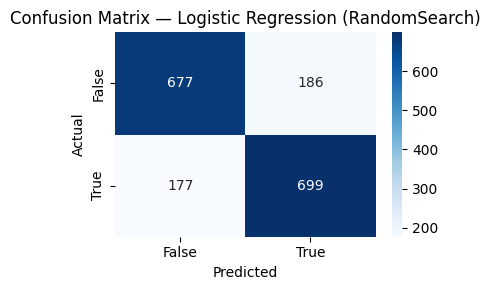

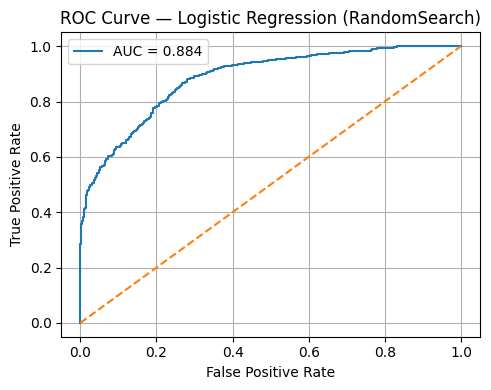


Tuning: Linear SVM

Evaluation — Linear SVM (RandomSearch)
              precision    recall  f1-score   support

       False       0.78      0.80      0.79       863
        True       0.80      0.78      0.79       876

    accuracy                           0.79      1739
   macro avg       0.79      0.79      0.79      1739
weighted avg       0.79      0.79      0.79      1739



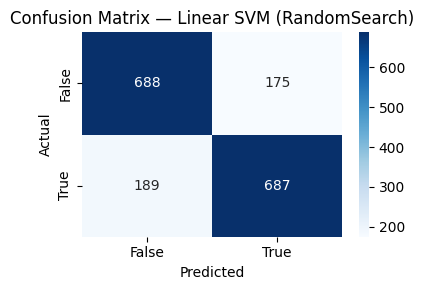

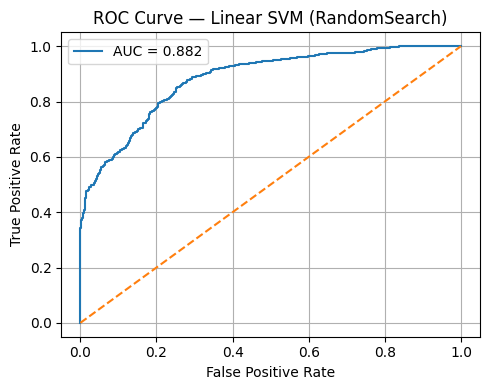


Tuning: Random Forest

Evaluation — Random Forest (RandomSearch)
              precision    recall  f1-score   support

       False       0.77      0.82      0.80       863
        True       0.81      0.76      0.79       876

    accuracy                           0.79      1739
   macro avg       0.79      0.79      0.79      1739
weighted avg       0.79      0.79      0.79      1739



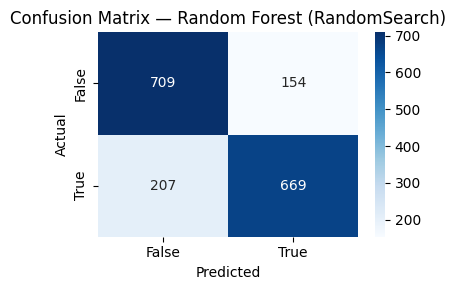

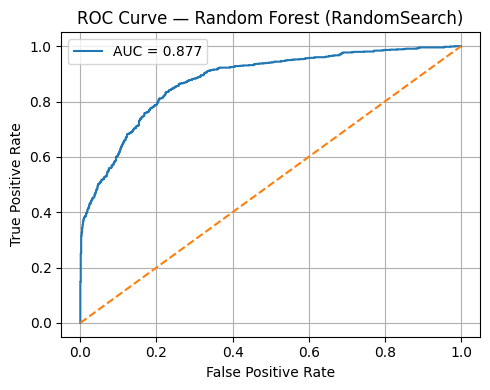


Tuning: CatBoost

Evaluation — CatBoost (RandomSearch)
              precision    recall  f1-score   support

       False       0.81      0.78      0.80       863
        True       0.79      0.83      0.81       876

    accuracy                           0.80      1739
   macro avg       0.80      0.80      0.80      1739
weighted avg       0.80      0.80      0.80      1739



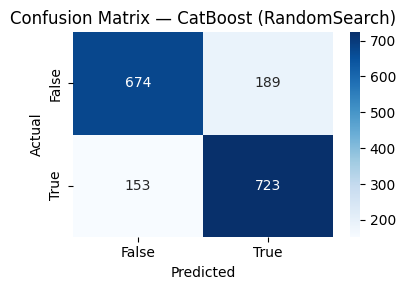

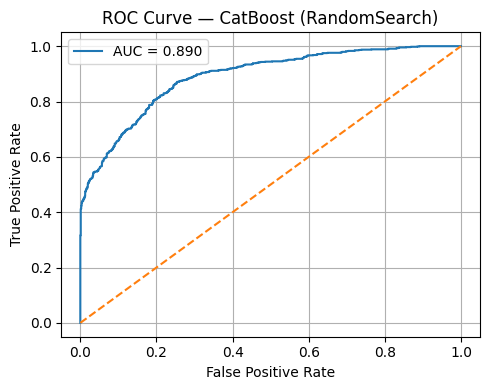


Tuning: XGBoost

Evaluation — XGBoost (RandomSearch)
              precision    recall  f1-score   support

       False       0.81      0.79      0.80       863
        True       0.80      0.82      0.81       876

    accuracy                           0.81      1739
   macro avg       0.81      0.81      0.81      1739
weighted avg       0.81      0.81      0.81      1739



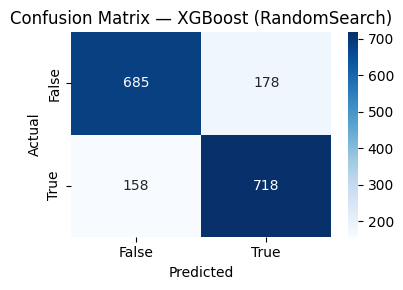

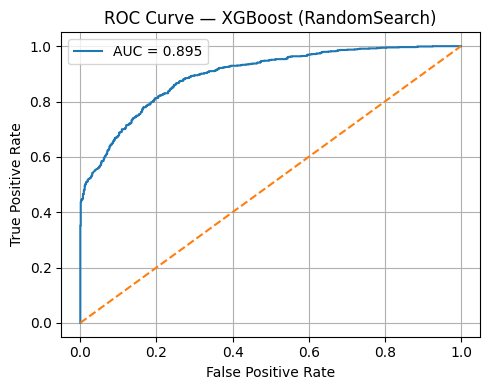


Top 3 Models for Voting Ensemble:
['XGBoost (RandomSearch)', 'CatBoost (RandomSearch)', 'Random Forest (RandomSearch)']

Evaluation — Voting Ensemble (RandomSearch Top 3)
              precision    recall  f1-score   support

       False       0.86      0.74      0.80       863
        True       0.77      0.88      0.82       876

    accuracy                           0.81      1739
   macro avg       0.82      0.81      0.81      1739
weighted avg       0.82      0.81      0.81      1739



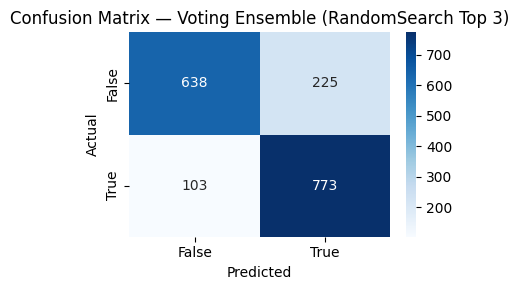

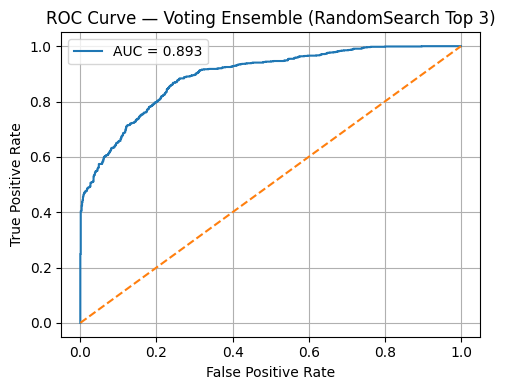

,Model,Accuracy,ROC AUC,PR AUC,F1,Precision,Recall,Best Params,Runtime (s)
6,Voting Ensemble (RandomSearch Top 3),0.811386,0.892629,0.904347,0.824973,0.774549,0.882420,Top 3 RandomSearch Models; Threshold: 0.38,16.47
5,XGBoost (RandomSearch),0.806786,0.894957,0.907882,0.810384,0.801339,0.819635,"{'clf__subsample': 0.8, 'clf__reg_lambda': 0.1...",148.65
4,CatBoost (RandomSearch),0.803335,0.889641,0.903374,0.808725,0.792763,0.825342,"{'clf__learning_rate': 0.05, 'clf__l2_leaf_reg...",623.50
0,Logistic Regression (Baseline),0.792409,0.879875,0.890106,0.795930,0.788354,0.803653,Default config,2.84
3,Random Forest (RandomSearch),0.792409,0.877099,0.887006,0.787522,0.812880,0.763699,"{'clf__n_estimators': 200, 'clf__min_samples_s...",154.38
1,Logistic Regression (RandomSearch),0.791259,0.883768,0.895407,0.793867,0.789831,0.797945,"{'clf__penalty': 'l2', 'clf__C': 0.1}",11.43
2,Linear SVM (RandomSearch),0.790684,0.881883,0.894019,0.790564,0.796984,0.784247,"{'clf__estimator__class_weight': None, 'clf__e...",23.18


In [8]:
CV_SPLITS = 5
N_ITER = 20
RANDOM_STATE = 42

model_defs = {
    "Logistic Regression": {
        "model": Pipeline(
            [
                ("full_pipeline", full_pipeline),
                (
                    "clf",
                    LogisticRegression(
                        max_iter=5000, solver="liblinear", random_state=RANDOM_STATE
                    ),
                ),
            ]
        ),
        "params": {
            "clf__C": [0.001, 0.01, 0.1, 1.0, 10.0, 100.0],
            "clf__penalty": ["l1", "l2"],
        },
    },
    "Linear SVM": {
        "model": Pipeline(
            [
                ("full_pipeline", full_pipeline),
                (
                    "clf",
                    CalibratedClassifierCV(
                        estimator=LinearSVC(max_iter=50000, random_state=RANDOM_STATE),
                        method="sigmoid",
                        cv=3,
                    ),
                ),
            ]
        ),
        "params": {
            "clf__estimator__C": [0.01, 0.1, 1, 10, 100],
            "clf__estimator__class_weight": ["balanced", None],
        },
    },
    "Random Forest": {
        "model": Pipeline(
            [
                ("full_pipeline", full_pipeline),
                (
                    "clf",
                    RandomForestClassifier(
                        class_weight="balanced", random_state=RANDOM_STATE
                    ),
                ),
            ]
        ),
        "params": {
            "clf__n_estimators": [100, 200, 300],
            "clf__max_depth": [5, 10, 15, None],
            "clf__min_samples_split": [2, 5, 10],
            "clf__min_samples_leaf": [1, 2, 4],
            "clf__max_features": ["sqrt", "log2"],
            "clf__bootstrap": [True, False],
        },
    },
    "CatBoost": {
        "model": Pipeline(
            [
                ("full_pipeline", full_pipeline),
                (
                    "clf",
                    CatBoostClassifier(
                        verbose=0, random_state=RANDOM_STATE, task_type="GPU"
                    ),
                ),
            ]
        ),
        "params": {
            "clf__iterations": [100, 200, 300],
            "clf__learning_rate": [0.005, 0.01, 0.05, 0.1, 0.2],
            "clf__depth": [4, 6, 8, 10],
            "clf__l2_leaf_reg": [1, 3, 5, 7],
        },
    },
    "XGBoost": {
        "model": Pipeline(
            [
                ("full_pipeline", full_pipeline),
                (
                    "to_dense",
                    FunctionTransformer(
                        lambda X: X.toarray() if hasattr(X, "toarray") else X
                    ),
                ),
                (
                    "clf",
                    XGBClassifier(
                        tree_method="hist",
                        device="cuda",
                        eval_metric="logloss",
                        random_state=RANDOM_STATE,
                    ),
                ),
            ]
        ),
        "params": {
            "clf__n_estimators": [100, 200, 300],
            "clf__learning_rate": [0.005, 0.01, 0.05, 0.1, 0.2],
            "clf__max_depth": [3, 5, 7, 9],
            "clf__subsample": [0.6, 0.8, 1.0],
            "clf__colsample_bytree": [0.6, 0.8, 1.0],
            "clf__reg_alpha": [0, 0.1, 1],
            "clf__reg_lambda": [0, 0.1, 1],
        },
    },
}

# Tune models with random search
cv = StratifiedKFold(n_splits=CV_SPLITS, shuffle=True, random_state=RANDOM_STATE)
best_models = {}

for name, cfg in model_defs.items():
    print(f"\nTuning: {name}")
    start = time.time()
    try:
        search = RandomizedSearchCV(
            estimator=cfg["model"],
            param_distributions=cfg["params"],
            n_iter=N_ITER,
            cv=cv,
            scoring="accuracy",
            n_jobs=1,
            random_state=RANDOM_STATE,
        )
        search.fit(X_train_split, y_train)
        best_model = search.best_estimator_
        best_models[name] = best_model

        y_proba = best_model.predict_proba(X_val)[:, 1]
        evaluate_and_record(
            name=name + " (RandomSearch)",
            model=best_model,
            X_val=X_val,
            y_val=y_val,
            start_time=start,
            proba=y_proba,
            threshold=0.5,
            extra_info=search.best_params_,
            results_list=ALL_RESULTS,
        )
    except Exception as e:
        print(f"Skipping {name} due to error:\n{e}")

# Voting ensemble from top 3
final_df = pd.DataFrame(ALL_RESULTS).sort_values("Accuracy", ascending=False)
top_models = (
    final_df[final_df["Model"].str.contains("RandomSearch")].head(3)["Model"].tolist()
)
print("\nTop 3 Models for Voting Ensemble:")
print(top_models)

ensemble_estimators = [
    (
        name.lower().replace(" ", "_").replace("(", "").replace(")", ""),
        best_models[name.replace(" (RandomSearch)", "")],
    )
    for name in top_models
]

voting_random = VotingClassifier(estimators=ensemble_estimators, voting="soft")
start = time.time()
voting_random.fit(X_train_split, y_train)
y_proba = voting_random.predict_proba(X_val)[:, 1]

# Threshold tuning
THRESHOLD_RANGE = np.arange(0.1, 0.91, 0.01)
accuracies = [accuracy_score(y_val, y_proba >= t) for t in THRESHOLD_RANGE]
best_thresh_random = THRESHOLD_RANGE[np.argmax(accuracies)]

evaluate_and_record(
    name="Voting Ensemble (RandomSearch Top 3)",
    model=voting_random,
    X_val=X_val,
    y_val=y_val,
    start_time=start,
    proba=y_proba,
    threshold=best_thresh_random,
    extra_info=f"Top 3 RandomSearch Models; Threshold: {best_thresh_random:.2f}",
    results_list=ALL_RESULTS,
)

final_df = pd.DataFrame(ALL_RESULTS).sort_values("Accuracy", ascending=False)
display(final_df)

### Permutation Feature Importance (Top Ensemble Model)

To better interpret model decisions, we apply **permutation feature importance** on the final Voting Ensemble derived from the top 3 models selected by Randomized Search. This method estimates how much each feature contributes to model performance by randomly shuffling values and measuring the resulting drop in accuracy.

We run permutation importance **only on final ensemble models**, rather than each individual trial, to reduce computational cost while still gaining interpretability. This approach strikes a balance between efficiency and insight, as feature importances can vary significantly across models optimized using:

- Random Search
- Optuna
- AutoML (e.g., FLAML)

By comparing the most important features for each strategy’s best model, we can identify which attributes consistently influence predictions and which ones are model-specific.

In this result:
- **Spending-related features** (VRDeck, Spa, FoodCourt) dominate the model’s decisions.
- Some engineered features like `GroupMember`, `GroupSize`, and `HomePlanet` show **negligible or even negative importance**, suggesting that they might add noise or complexity in ensemble voting.

These insights help validate feature engineering choices and guide potential feature pruning or transformation strategies.


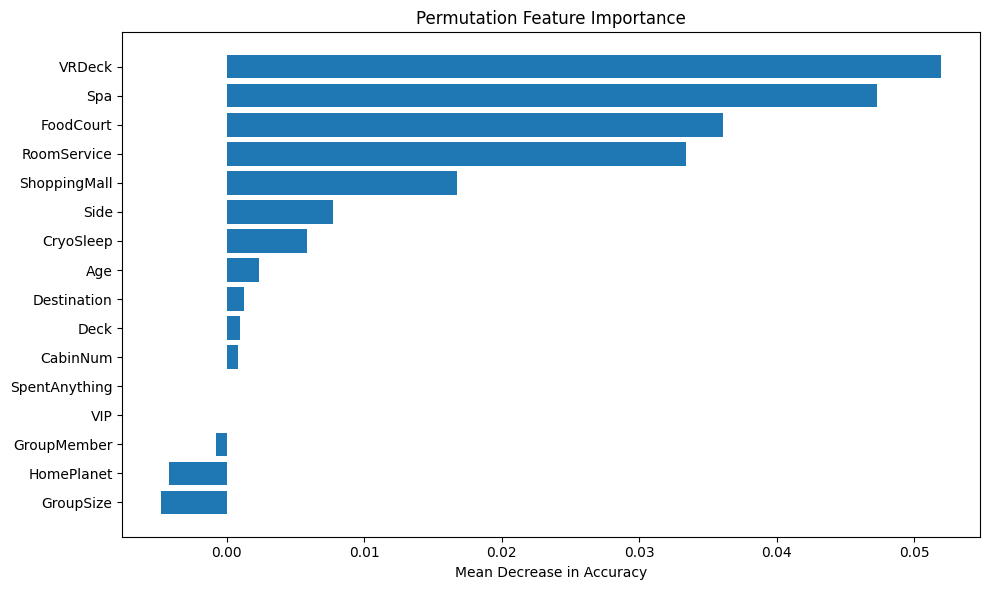

In [9]:
plot_permutation_importance(voting_random, X_val, y_val)

### 10. Optuna Search with Ensemble Voting

This section uses **Optuna**, a hyperparameter optimization framework based on Bayesian sampling, to explore model configurations more efficiently than grid or random search. For each supported model, we define:

- A `space` function using `lambda trial` to specify the hyperparameter search distribution.
- A `build` function using `lambda p` to construct a pipeline with the sampled parameters.

#### Models Tuned with Optuna
We ran 20 Optuna trials each for the following models:
- Logistic Regression
- Linear SVM (calibrated for probabilities)
- Random Forest
- CatBoost (GPU-accelerated)
- XGBoost (GPU-accelerated)

The models were evaluated via **Stratified K-Fold CV (k=5)** and scored on validation accuracy.

#### Ensemble Creation
The top 3 performing Optuna-tuned models were:
- `XGBoost`
- `CatBoost`
- `Linear SVM`

These were combined into a **soft-voting ensemble**, and the classification threshold was tuned on the validation set to maximize accuracy. The ensemble achieved **81.1% accuracy**, closely matching the result from the Randomized Search ensemble.

#### Next Step
Permutation feature importance will be applied to this ensemble (as done for Random Search), as it helps uncover distinct patterns of feature influence across different optimization strategies.


[I 2025-07-21 12:25:22,660] A new study created in memory with name: no-name-c939bc58-47dd-4f2b-be54-385807866256



Tuning: Logistic Regression


[I 2025-07-21 12:25:23,543] Trial 0 finished with value: 0.7798395647249274 and parameters: {'C': 0.0053518551781371135, 'penalty': 'l2'}. Best is trial 0 with value: 0.7798395647249274.
[I 2025-07-21 12:25:24,550] Trial 1 finished with value: 0.7687652897092823 and parameters: {'C': 8.076070032407738, 'penalty': 'l2'}. Best is trial 0 with value: 0.7798395647249274.
[I 2025-07-21 12:25:25,400] Trial 2 finished with value: 0.7891859797568129 and parameters: {'C': 0.03620986364827895, 'penalty': 'l1'}. Best is trial 2 with value: 0.7891859797568129.
[I 2025-07-21 12:25:26,242] Trial 3 finished with value: 0.7778265209543365 and parameters: {'C': 0.011272666817959735, 'penalty': 'l1'}. Best is trial 2 with value: 0.7891859797568129.
[I 2025-07-21 12:25:27,070] Trial 4 finished with value: 0.7661784648485381 and parameters: {'C': 0.005665237728077208, 'penalty': 'l1'}. Best is trial 2 with value: 0.7891859797568129.
[I 2025-07-21 12:25:28,132] Trial 5 finished with value: 0.73828093240720


Evaluation — Logistic Regression (Optuna)
              precision    recall  f1-score   support

       False       0.79      0.79      0.79       863
        True       0.79      0.79      0.79       876

    accuracy                           0.79      1739
   macro avg       0.79      0.79      0.79      1739
weighted avg       0.79      0.79      0.79      1739



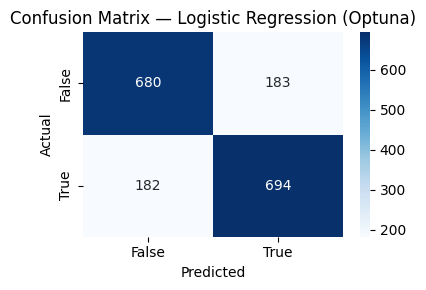

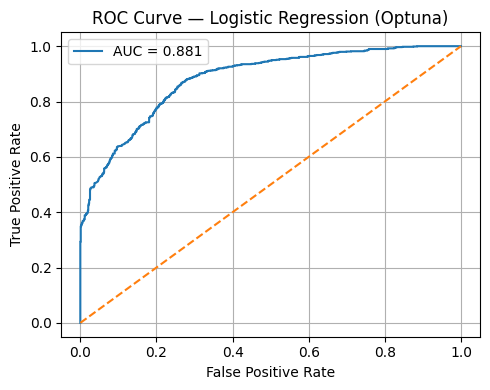

[I 2025-07-21 12:25:39,553] A new study created in memory with name: no-name-6ab8a64d-87a7-44e3-aff8-18767e29d075



Tuning: Linear SVM


[I 2025-07-21 12:25:42,108] Trial 0 finished with value: 0.7863099369533848 and parameters: {'C': 0.1346532782586668, 'class_weight': None}. Best is trial 0 with value: 0.7863099369533848.
[I 2025-07-21 12:25:44,878] Trial 1 finished with value: 0.7645961447951631 and parameters: {'C': 13.107730418536827, 'class_weight': None}. Best is trial 0 with value: 0.7863099369533848.
[I 2025-07-21 12:25:47,333] Trial 2 finished with value: 0.7683343591122788 and parameters: {'C': 2.6281891837366738, 'class_weight': 'balanced'}. Best is trial 0 with value: 0.7863099369533848.
[I 2025-07-21 12:25:49,785] Trial 3 finished with value: 0.7865976032976638 and parameters: {'C': 0.005708511469166147, 'class_weight': None}. Best is trial 3 with value: 0.7865976032976638.
[I 2025-07-21 12:25:52,125] Trial 4 finished with value: 0.7858784891569132 and parameters: {'C': 0.1872918353271327, 'class_weight': None}. Best is trial 3 with value: 0.7865976032976638.
[I 2025-07-21 12:25:54,481] Trial 5 finished wi


Evaluation — Linear SVM (Optuna)
              precision    recall  f1-score   support

       False       0.79      0.79      0.79       863
        True       0.80      0.80      0.80       876

    accuracy                           0.80      1739
   macro avg       0.80      0.80      0.80      1739
weighted avg       0.80      0.80      0.80      1739



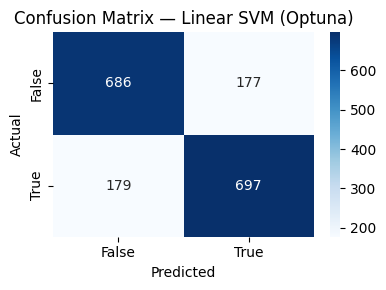

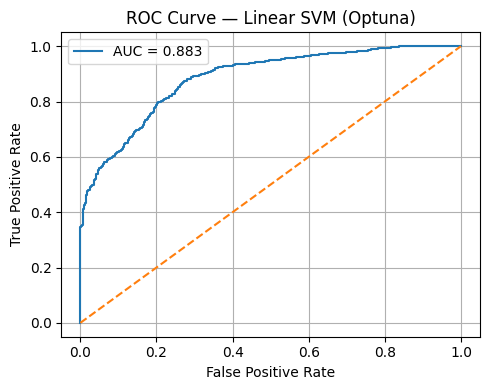

[I 2025-07-21 12:26:26,788] A new study created in memory with name: no-name-f8683cd8-3bb3-49e2-97e1-555b16c5f3f4



Tuning: Random Forest


[I 2025-07-21 12:26:29,498] Trial 0 finished with value: 0.7388560582159722 and parameters: {'n_estimators': 189, 'max_depth': 15, 'min_samples_split': 7, 'min_samples_leaf': 4, 'max_features': 'log2', 'bootstrap': True}. Best is trial 0 with value: 0.7388560582159722.
[I 2025-07-21 12:26:43,315] Trial 1 finished with value: 0.7434584094047552 and parameters: {'n_estimators': 284, 'max_depth': 19, 'min_samples_split': 2, 'min_samples_leaf': 2, 'max_features': 'sqrt', 'bootstrap': True}. Best is trial 1 with value: 0.7434584094047552.
[I 2025-07-21 12:26:47,981] Trial 2 finished with value: 0.7418767099907421 and parameters: {'n_estimators': 53, 'max_depth': 22, 'min_samples_split': 3, 'min_samples_leaf': 4, 'max_features': 'sqrt', 'bootstrap': False}. Best is trial 1 with value: 0.7434584094047552.
[I 2025-07-21 12:26:52,596] Trial 3 finished with value: 0.7379933695028161 and parameters: {'n_estimators': 270, 'max_depth': 11, 'min_samples_split': 6, 'min_samples_leaf': 3, 'max_feature


Evaluation — Random Forest (Optuna)
              precision    recall  f1-score   support

       False       0.71      0.84      0.77       863
        True       0.80      0.66      0.73       876

    accuracy                           0.75      1739
   macro avg       0.76      0.75      0.75      1739
weighted avg       0.76      0.75      0.75      1739



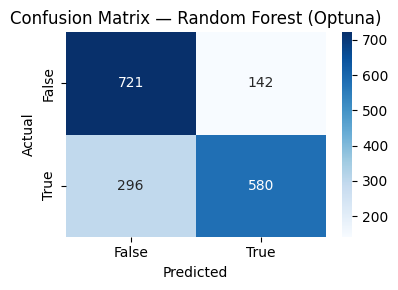

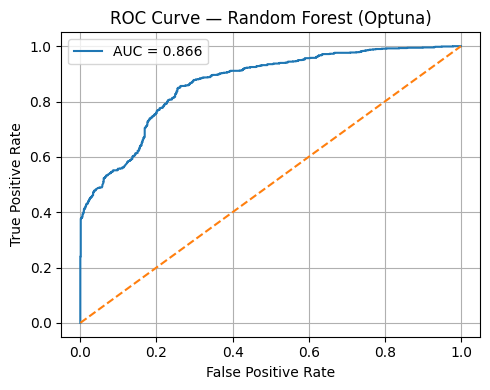

[I 2025-07-21 12:28:56,024] A new study created in memory with name: no-name-1f94cee3-1591-4242-a39b-2b6b897cefe2



Tuning: CatBoost


[I 2025-07-21 12:29:27,394] Trial 0 finished with value: 0.7956583173432499 and parameters: {'iterations': 299, 'learning_rate': 0.223881486225432, 'depth': 4, 'l2_leaf_reg': 2.827982157940576}. Best is trial 0 with value: 0.7956583173432499.
[I 2025-07-21 12:30:05,519] Trial 1 finished with value: 0.7926383896477354 and parameters: {'iterations': 425, 'learning_rate': 0.01188479673855977, 'depth': 4, 'l2_leaf_reg': 3.2898717000399804}. Best is trial 0 with value: 0.7956583173432499.
[I 2025-07-21 12:30:36,757] Trial 2 finished with value: 0.7830042048316773 and parameters: {'iterations': 266, 'learning_rate': 0.006841919449957153, 'depth': 5, 'l2_leaf_reg': 4.22490092254764}. Best is trial 0 with value: 0.7956583173432499.
[I 2025-07-21 12:31:13,022] Trial 3 finished with value: 0.8012670352574878 and parameters: {'iterations': 397, 'learning_rate': 0.054181751895955976, 'depth': 4, 'l2_leaf_reg': 5.507308028966257}. Best is trial 3 with value: 0.8012670352574878.
[I 2025-07-21 12:31:


Evaluation — CatBoost (Optuna)
              precision    recall  f1-score   support

       False       0.82      0.78      0.80       863
        True       0.79      0.83      0.81       876

    accuracy                           0.80      1739
   macro avg       0.80      0.80      0.80      1739
weighted avg       0.80      0.80      0.80      1739



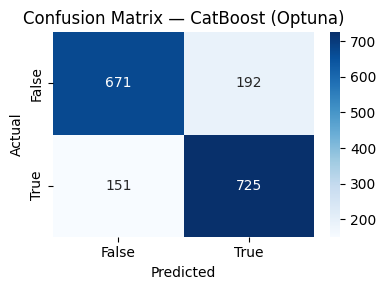

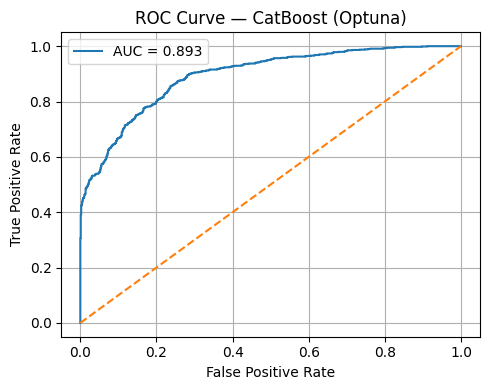

[I 2025-07-21 12:43:37,413] A new study created in memory with name: no-name-70a840a1-f610-4ceb-8cca-84996ce53d57



Tuning: XGBoost


[I 2025-07-21 12:43:43,068] Trial 0 finished with value: 0.7985335326275285 and parameters: {'n_estimators': 100, 'learning_rate': 0.045585006213925264, 'max_depth': 8, 'subsample': 0.946196006336687, 'colsample_bytree': 0.7974876604215835, 'reg_alpha': 2.5218365260527733, 'reg_lambda': 8.978456294799743}. Best is trial 0 with value: 0.7985335326275285.
[I 2025-07-21 12:43:47,522] Trial 1 finished with value: 0.8012661042984448 and parameters: {'n_estimators': 168, 'learning_rate': 0.12548203195297625, 'max_depth': 5, 'subsample': 0.8716806253169296, 'colsample_bytree': 0.523405199600707, 'reg_alpha': 9.05713134463507, 'reg_lambda': 4.5015604812495225}. Best is trial 1 with value: 0.8012661042984448.
[I 2025-07-21 12:43:54,617] Trial 2 finished with value: 0.7922072521709449 and parameters: {'n_estimators': 197, 'learning_rate': 0.2666319754180781, 'max_depth': 10, 'subsample': 0.7014850390443601, 'colsample_bytree': 0.6174113856928277, 'reg_alpha': 5.3078175383474875, 'reg_lambda': 2.


Evaluation — XGBoost (Optuna)
              precision    recall  f1-score   support

       False       0.81      0.80      0.81       863
        True       0.81      0.82      0.81       876

    accuracy                           0.81      1739
   macro avg       0.81      0.81      0.81      1739
weighted avg       0.81      0.81      0.81      1739



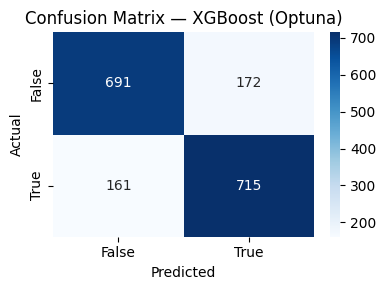

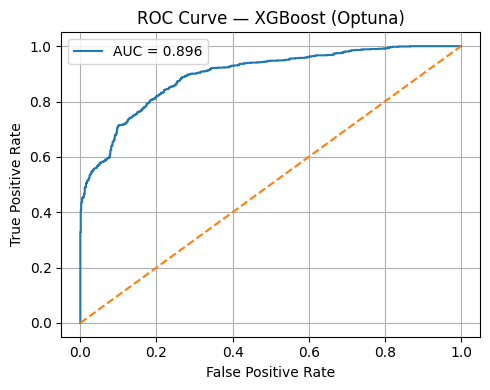


Creating Voting Ensemble from Top 3 Optuna Models:
['XGBoost (Optuna)', 'CatBoost (Optuna)', 'Linear SVM (Optuna)']

Evaluation — Voting Ensemble (Optuna)
              precision    recall  f1-score   support

       False       0.85      0.75      0.80       863
        True       0.78      0.87      0.82       876

    accuracy                           0.81      1739
   macro avg       0.82      0.81      0.81      1739
weighted avg       0.82      0.81      0.81      1739



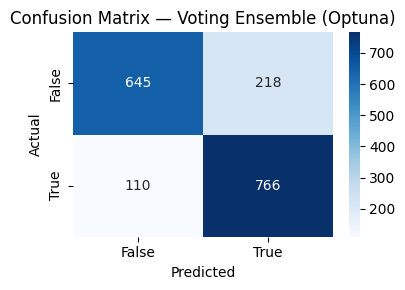

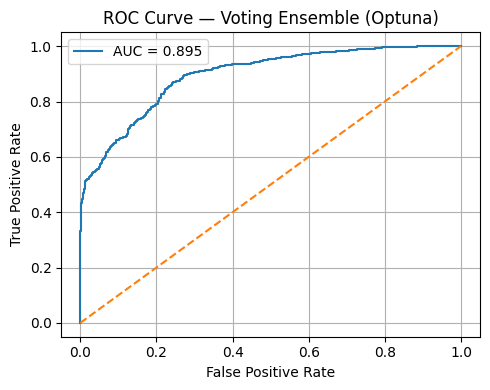

,Model,Accuracy,ROC AUC,PR AUC,F1,Precision,Recall,Best Params,Runtime (s)
6,Voting Ensemble (RandomSearch Top 3),0.811386,0.892629,0.904347,0.824973,0.774549,0.882420,Top 3 RandomSearch Models; Threshold: 0.38,16.47
12,Voting Ensemble (Optuna),0.811386,0.894783,0.906901,0.823656,0.778455,0.874429,Top 3 Optuna; Threshold: 0.41,12.84
11,XGBoost (Optuna),0.808511,0.895690,0.908946,0.811117,0.806088,0.816210,"{'n_estimators': 275, 'learning_rate': 0.08455...",169.84
5,XGBoost (RandomSearch),0.806786,0.894957,0.907882,0.810384,0.801339,0.819635,"{'clf__subsample': 0.8, 'clf__reg_lambda': 0.1...",148.65
4,CatBoost (RandomSearch),0.803335,0.889641,0.903374,0.808725,0.792763,0.825342,"{'clf__learning_rate': 0.05, 'clf__l2_leaf_reg...",623.50
10,CatBoost (Optuna),0.802760,0.893123,0.905447,0.808701,0.790622,0.827626,"{'iterations': 376, 'learning_rate': 0.0264490...",881.20
8,Linear SVM (Optuna),0.795285,0.883044,0.894871,0.796571,0.797483,0.795662,"{'C': 0.02168594117701798, 'class_weight': None}",47.05
3,Random Forest (RandomSearch),0.792409,0.877099,0.887006,0.787522,0.812880,0.763699,"{'clf__n_estimators': 200, 'clf__min_samples_s...",154.38
0,Logistic Regression (Baseline),0.792409,0.879875,0.890106,0.795930,0.788354,0.803653,Default config,2.84
1,Logistic Regression (RandomSearch),0.791259,0.883768,0.895407,0.793867,0.789831,0.797945,"{'clf__penalty': 'l2', 'clf__C': 0.1}",11.43


In [10]:
N_TRIALS = 20

# Define Optuna model search spaces and builders
optuna_model_defs = {
    "Logistic Regression": {
        "space": lambda trial: {
            "C": trial.suggest_float("C", 0.001, 100.0, log=True),  # Broader log-scale
            "penalty": trial.suggest_categorical("penalty", ["l1", "l2"]),
        },
        "build": lambda p: Pipeline(
            [
                ("full_pipeline", full_pipeline),
                (
                    "clf",
                    LogisticRegression(
                        **p,
                        solver="liblinear",
                        max_iter=5000,
                        random_state=RANDOM_STATE,
                    ),
                ),
            ]
        ),
    },
    "Linear SVM": {
        "space": lambda trial: {
            "C": trial.suggest_float("C", 0.001, 100.0, log=True),  # Broader
            "class_weight": trial.suggest_categorical(
                "class_weight", ["balanced", None]
            ),
        },
        "build": lambda p: Pipeline(
            [
                ("full_pipeline", full_pipeline),
                (
                    "clf",
                    CalibratedClassifierCV(
                        estimator=LinearSVC(
                            **p, max_iter=50000, random_state=RANDOM_STATE
                        ),
                        method="sigmoid",
                        cv=3,
                    ),
                ),
            ]
        ),
    },
    "Random Forest": {
        "space": lambda trial: {
            "n_estimators": trial.suggest_int("n_estimators", 50, 300),
            "max_depth": trial.suggest_int("max_depth", 5, 25),
            "min_samples_split": trial.suggest_int("min_samples_split", 2, 10),
            "min_samples_leaf": trial.suggest_int("min_samples_leaf", 1, 4),
            "max_features": trial.suggest_categorical("max_features", ["sqrt", "log2"]),
            "bootstrap": trial.suggest_categorical("bootstrap", [True, False]),
        },
        "build": lambda p: Pipeline(
            [
                ("full_pipeline", full_pipeline),
                (
                    "clf",
                    RandomForestClassifier(
                        **p, class_weight="balanced", random_state=RANDOM_STATE
                    ),
                ),
            ]
        ),
    },
    "CatBoost": {
        "space": lambda trial: {
            "iterations": trial.suggest_int("iterations", 50, 500),
            "learning_rate": trial.suggest_float("learning_rate", 0.005, 0.3, log=True),
            "depth": trial.suggest_int("depth", 4, 12),
            "l2_leaf_reg": trial.suggest_float("l2_leaf_reg", 1, 10),
        },
        "build": lambda p: Pipeline(
            [
                ("full_pipeline", full_pipeline),
                (
                    "clf",
                    CatBoostClassifier(
                        **p, verbose=0, task_type="GPU", random_state=RANDOM_STATE
                    ),
                ),
            ]
        ),
    },
    "XGBoost": {
        "space": lambda trial: {
            "n_estimators": trial.suggest_int("n_estimators", 50, 500),
            "learning_rate": trial.suggest_float("learning_rate", 0.005, 0.3, log=True),
            "max_depth": trial.suggest_int("max_depth", 3, 12),
            "subsample": trial.suggest_float("subsample", 0.5, 1.0),
            "colsample_bytree": trial.suggest_float("colsample_bytree", 0.5, 1.0),
            "reg_alpha": trial.suggest_float("reg_alpha", 0, 10),
            "reg_lambda": trial.suggest_float("reg_lambda", 0, 10),
        },
        "build": lambda p: Pipeline(
            [
                ("full_pipeline", full_pipeline),
                (
                    "clf",
                    XGBClassifier(
                        **p,
                        tree_method="hist",
                        device="cuda",
                        eval_metric="logloss",
                        random_state=RANDOM_STATE,
                    ),
                ),
            ]
        ),
    },
}

# Run Optuna tuning
cv = StratifiedKFold(n_splits=CV_SPLITS, shuffle=True, random_state=RANDOM_STATE)
optuna_models = {}

for name, cfg in optuna_model_defs.items():
    print(f"\nTuning: {name}")
    model_name, model = tune_and_evaluate_with_optuna(
        name=name,
        cfg=cfg,
        X_train=X_train_split,
        y_train=y_train,
        X_val=X_val,
        y_val=y_val,
        cv=cv,
        n_trials=N_TRIALS,
        results_list=ALL_RESULTS,
    )
    optuna_models[model_name] = model

# Voting ensemble from top 3 Optuna models
final_df = pd.DataFrame(ALL_RESULTS).sort_values(by="Accuracy", ascending=False)
top_models = (
    final_df[final_df["Model"].str.contains("Optuna")].head(3)["Model"].tolist()
)
print(f"\nCreating Voting Ensemble from Top 3 Optuna Models:")
print(top_models)

ensemble_estimators = [
    (
        f"model_{i}_{name.lower().replace(' ', '_').replace('(', '').replace(')', '')}",
        optuna_models[name],
    )
    for i, name in enumerate(top_models)
]

voting_optuna = VotingClassifier(estimators=ensemble_estimators, voting="soft")
start = time.time()
voting_optuna.fit(X_train_split, y_train)

# Threshold tuning
THRESHOLD_RANGE = np.arange(0.1, 0.91, 0.01)
val_proba = voting_optuna.predict_proba(X_val)[:, 1]
accuracies = [accuracy_score(y_val, val_proba >= t) for t in THRESHOLD_RANGE]
best_thresh = THRESHOLD_RANGE[np.argmax(accuracies)]

evaluate_and_record(
    name="Voting Ensemble (Optuna)",
    model=voting_optuna,
    X_val=X_val,
    y_val=y_val,
    start_time=start,
    threshold=best_thresh,
    proba=val_proba,
    extra_info=f"Top 3 Optuna; Threshold: {best_thresh:.2f}",
    results_list=ALL_RESULTS,
)

final_df = pd.DataFrame(ALL_RESULTS).sort_values("Accuracy", ascending=False)
display(final_df)

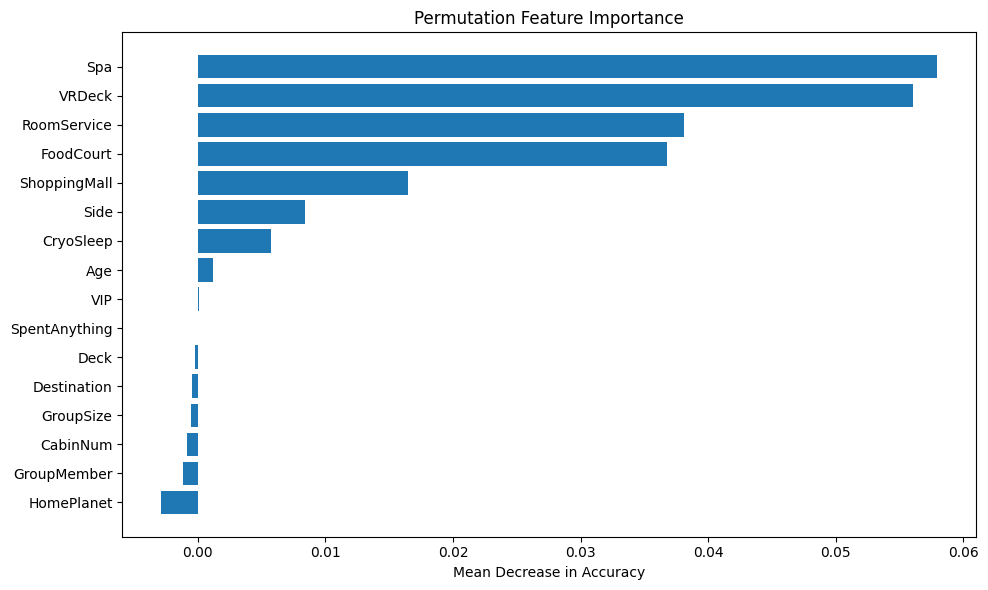

In [11]:
plot_permutation_importance(voting_optuna, X_val, y_val)

### 11. FLAML AutoML Search

In this section, we leverage **FLAML (Fast Lightweight AutoML)** to automatically select and tune a high-performing model within a **5-minute time budget (300 seconds)**. FLAML efficiently explores both model types and hyperparameter configurations without relying on exhaustive search.

#### Configuration
- **Task**: Binary classification (`Transported`)
- **Metric**: Accuracy
- **Time Budget**: 300 seconds
- **Search Space**: Restricted to the following estimators:
  - `xgboost`
  - `catboost`
  - `lrl1` (L1-regularized logistic regression)
  - `rf` (random forest)
  - `extra_tree` (extremely randomized trees)

#### Results
FLAML selected **CatBoost** as the best estimator, with a tuned learning rate and large number of trees (`8192`) and completed training in under one second for the best config. After threshold tuning, the model achieved:

- **Accuracy**: 80.6%
- **F1 Score**: 0.81
- **ROC AUC**: 0.89
- **PR AUC**: 0.90

These results are competitive with both Randomized Search and Optuna ensembles.

#### Feature Importance
Permutation importance was also applied here for interpretability. Although not computed for every FLAML trial, this helps identify which features the final selected model relies on most.

Best model found by FLAML:
Estimator: catboost
Best config: {'early_stopping_rounds': 10, 'learning_rate': np.float64(0.1494260511173552), 'n_estimators': 8192}
Best loss: 0.19672012785170856
Training duration (s): 0.5680086612701416

Best Threshold: 0.45

Evaluation — FLAML (Tuned Threshold)
              precision    recall  f1-score   support

       False       0.83      0.77      0.80       863
        True       0.79      0.84      0.81       876

    accuracy                           0.81      1739
   macro avg       0.81      0.81      0.81      1739
weighted avg       0.81      0.81      0.81      1739



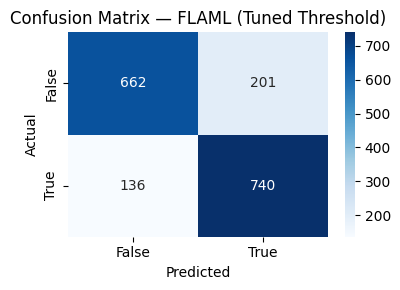

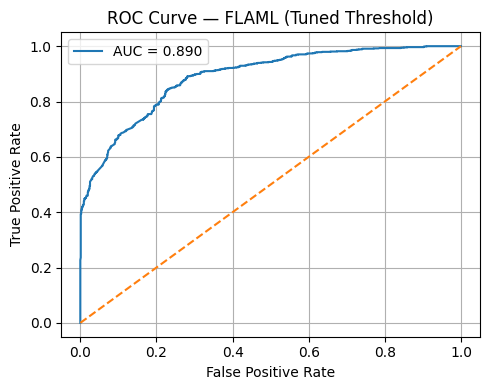

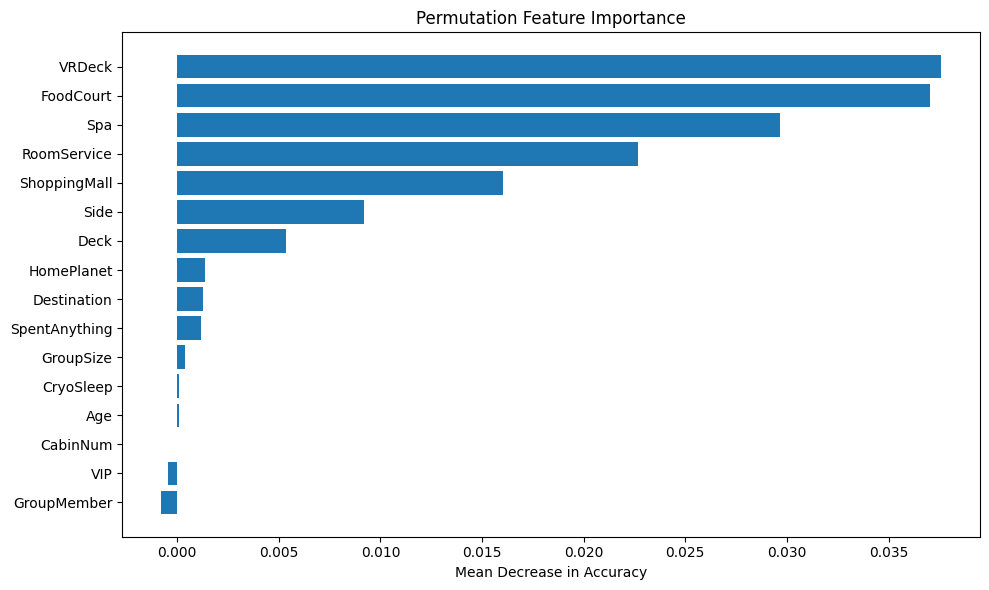

,Model,Accuracy,ROC AUC,PR AUC,F1,Precision,Recall,Best Params,Runtime (s)
12,Voting Ensemble (Optuna),0.811386,0.894783,0.906901,0.823656,0.778455,0.874429,Top 3 Optuna; Threshold: 0.41,12.84
6,Voting Ensemble (RandomSearch Top 3),0.811386,0.892629,0.904347,0.824973,0.774549,0.882420,Top 3 RandomSearch Models; Threshold: 0.38,16.47
11,XGBoost (Optuna),0.808511,0.895690,0.908946,0.811117,0.806088,0.816210,"{'n_estimators': 275, 'learning_rate': 0.08455...",169.84
5,XGBoost (RandomSearch),0.806786,0.894957,0.907882,0.810384,0.801339,0.819635,"{'clf__subsample': 0.8, 'clf__reg_lambda': 0.1...",148.65
13,FLAML (Tuned Threshold),0.806210,0.889599,0.901164,0.814529,0.786397,0.844749,Estimator: catboost; Threshold: 0.45,300.46
4,CatBoost (RandomSearch),0.803335,0.889641,0.903374,0.808725,0.792763,0.825342,"{'clf__learning_rate': 0.05, 'clf__l2_leaf_reg...",623.50
10,CatBoost (Optuna),0.802760,0.893123,0.905447,0.808701,0.790622,0.827626,"{'iterations': 376, 'learning_rate': 0.0264490...",881.20
8,Linear SVM (Optuna),0.795285,0.883044,0.894871,0.796571,0.797483,0.795662,"{'C': 0.02168594117701798, 'class_weight': None}",47.05
0,Logistic Regression (Baseline),0.792409,0.879875,0.890106,0.795930,0.788354,0.803653,Default config,2.84
3,Random Forest (RandomSearch),0.792409,0.877099,0.887006,0.787522,0.812880,0.763699,"{'clf__n_estimators': 200, 'clf__min_samples_s...",154.38


In [12]:
TIME_BUDGET = 300
FLAML_ESTIMATORS = ["xgboost", "catboost", "lrl1", "rf", "extra_tree"]

automl = AutoML()

start = time.time()
automl.fit(
    X_train=X_train_split,
    y_train=y_train,
    task="classification",
    time_budget=TIME_BUDGET,
    metric="accuracy",
    estimator_list=FLAML_ESTIMATORS,
    log_file_name="flaml.log",
    verbose=2,
)

print("Best model found by FLAML:")
print("Estimator:", automl.best_estimator)
print("Best config:", automl.best_config)
print("Best loss:", automl.best_loss)
print("Training duration (s):", automl.best_config_train_time)

y_proba = automl.predict_proba(X_val)[:, 1]

accuracies = [accuracy_score(y_val, y_proba >= t) for t in THRESHOLD_RANGE]
best_idx = np.argmax(accuracies)
best_threshold_flaml = THRESHOLD_RANGE[best_idx]
print(f"\nBest Threshold: {best_threshold_flaml:.2f}")

evaluate_and_record(
    name="FLAML (Tuned Threshold)",
    model=automl,
    X_val=X_val,
    y_val=y_val,
    proba=y_proba,
    threshold=best_threshold_flaml,
    start_time=start,
    extra_info=f"Estimator: {automl.best_estimator}; Threshold: {best_threshold_flaml:.2f}",
    results_list=ALL_RESULTS,
)

plot_permutation_importance(automl, X_val, y_val)

final_df = pd.DataFrame(ALL_RESULTS).sort_values("Accuracy", ascending=False)
display(final_df)

### 12. Final Model Retraining and Submission Generation

In this final step, the best model—identified from the validation leaderboard—is retrained on the **entire training dataset** to maximize predictive performance on the unseen test set.

#### Key Steps

- **Test Set Preparation**: `test.csv` is loaded and transformed using the same `FeatureEngineer` pipeline to maintain consistency with training features.
- **Model Selection**: The top-performing model is retrieved from the evaluation leaderboard (`ALL_RESULTS`). Depending on whether it came from:
  - **FLAML**: Uses the `automl` object and transforms both training and test features.
  - **Optuna or Random Search**: Uses the corresponding voting ensemble (`voting_optuna` or `voting_random`).
  - **Baseline**: Falls back to the logistic regression pipeline.
- **Threshold Handling**: Applies the optimized classification threshold recorded during evaluation (if available); otherwise defaults to `0.5`.
- **Retraining**: The selected model is re-fit on the entire training dataset (`train.csv`) using the full feature space.
- **Test Prediction**: Predicts probabilities and converts them to boolean outputs using the chosen threshold.
- **Submission**: Outputs a CSV file in the required format:
  - File name is dynamically generated using the model name.
  - Contains `PassengerId` and predicted `Transported` status.

This ensures that the final model used for submission is trained on the maximum available data with the most competitive configuration.

In [13]:
test_df_raw = pd.read_csv("test.csv")
passenger_ids = test_df_raw["PassengerId"].copy()
test_df_fe = FeatureEngineer().transform(test_df_raw)

print("\nRetraining Best Model on Full Data from 'train.csv'")
train_full = pd.read_csv("train.csv")
X_full_raw = train_full.drop(columns=["Transported"])
y_full = train_full["Transported"].astype(int)

leaderboard_df = pd.DataFrame(ALL_RESULTS).sort_values("Accuracy", ascending=False)
best_model_row = leaderboard_df.iloc[0]
best_model_name = best_model_row["Model"]
print(f"Best Model: {best_model_name}")

is_flaml = "FLAML" in best_model_name
is_optuna = "Optuna" in best_model_name
is_random = "RandomSearch" in best_model_name

extra_info = best_model_row["Best Params"]
final_threshold = (
    float(extra_info.split("Threshold:")[-1].strip())
    if "Threshold:" in str(extra_info)
    else 0.5
)
print(f"Using Threshold: {final_threshold:.2f}")

print("Training model on full dataset")
if is_flaml:
    final_model = automl
    X_full_fe = FeatureEngineer().transform(X_full_raw)
    final_model.fit(X_full_fe, y_full)
    X_test = test_df_fe

else:
    if is_optuna:
        final_model = voting_optuna
    elif is_random:
        final_model = voting_random
    else:
        final_model = baseline_pipeline

    final_model.fit(X_full_raw, y_full)
    X_test = test_df_raw

y_test_proba = final_model.predict_proba(X_test)[:, 1]
y_test_pred = (y_test_proba >= final_threshold).astype(bool)

submission = pd.DataFrame({"PassengerId": passenger_ids, "Transported": y_test_pred})

filename = f"submission_final_{best_model_name.lower().replace(' ', '_').replace('(', '').replace(')', '')}.csv"
submission.to_csv(filename, index=False)
print(f"Final submission saved as: {filename}")


Retraining Best Model on Full Data from 'train.csv'
Best Model: Voting Ensemble (Optuna)
Using Threshold: 0.41
Training model on full dataset
Final submission saved as: submission_final_voting_ensemble_optuna.csv


### 13. Conclusion

In this project, we explored multiple strategies for binary classification on the **Spaceship Titanic** dataset. Our workflow covered:

- Thorough **EDA** and feature inspection.
- Custom **feature engineering** and **preprocessing pipelines**.
- A variety of model training and tuning approaches:
  - Baseline logistic regression.
  - Hyperparameter tuning with **Randomized Search** and **Optuna**.
  - Automated modeling with **FLAML**.
  - **Voting ensembles** built from top-performing models.
- Evaluation using accuracy, precision, recall, F1, AUC metrics, and **threshold optimization**.
- **Permutation feature importance** for interpretability of ensemble and AutoML models.

#### Final Result
- The **best-performing model** on validation was a **voting ensemble (Optuna)** and a **FLAML-tuned CatBoost**, both achieving **~81.1% validation accuracy**.
- The **final submission**, generated from the top model retrained on the full dataset, achieved a **private leaderboard score of 0.80126**.

This indicates that the optimized pipeline is well-generalized and competitive on unseen data.

--- 

This concludes the notebook. Future improvements could include:
- Ensembling across multiple optimization strategies.
- Advanced feature selection or dimensionality reduction.
- Additional domain-informed features (e.g., family groupings, cabin location patterns).

Thank you for reading!
